# POC 1: Deeplab on Cityscape dataset

## Import

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/ProjetOpenClassrooms/OnboadSystem_Model/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ProjetOpenClassrooms/OnboadSystem_Model


In [ ]:
!pip install -q mlflow
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

from collections import Counter

import mlflow
import mlflow.pytorch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
from torch.amp import autocast

import segmentation_models_pytorch as smp


import torchvision.models as models
import torch.nn.functional as F
import torchvision

import torchvision.models.segmentation as models
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

import os, cv2, random, numpy as np
from glob import glob

import torch, numpy as np, cv2, random
from torch.utils.data import Dataset, DataLoader
import os
from glob import glob

import math, random, time
import torch
from torch import optim, nn

import mlflow
import time
import torch
from torch.utils.data import DataLoader

In [ ]:
CITYSCAPES_ROOT = "./data"

LEFTIMG_DIR = os.path.join(CITYSCAPES_ROOT, "leftImg8bit")
MASK_DIR    = os.path.join(CITYSCAPES_ROOT, "gtFine")

TRAIN_IMG_DIR = os.path.join(LEFTIMG_DIR, "train")
VAL_IMG_DIR   = os.path.join(LEFTIMG_DIR, "val")
TEST_IMG_DIR  = os.path.join(LEFTIMG_DIR, "test")

TRAIN_MASK_DIR = os.path.join(MASK_DIR, "train")
VAL_MASK_DIR   = os.path.join(MASK_DIR, "val")
TEST_MASK_DIR  = os.path.join(MASK_DIR, "test")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 8
IMG_WIDTH, IMG_HEIGHT = 512, 256
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 16

torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.get_device_name()

(True, 0, 'Tesla T4')

## Class remapping and resizing


In [ ]:
# Mapping class ID
CITYSCAPES_8_CLASSES = {
        # flat
        7: 0, 8: 0, 9: 7, 10: 7,  # road, sidewalk, parking, rail track

        # human
        24: 1, 25: 1,  # person, rider

        # vehicle
        26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2,  # car, truck, bus, train, motorcycle, etc.

        # construction
        11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 4,  # building, wall, fence, etc.

        # object
        18: 4, 19: 4, 20: 4,  # pole, traffic light/sign

        # nature
        21: 5, 22: 5,  # vegetation, terrain

        # sky
        23: 6,  # sky

        # void (everything else)
}

def remap_mask(mask):
    """
    Remap the original Cityscapes mask classes to a reduced set of 8 target classes.

    This function takes an input mask where pixel values correspond to the
    original Cityscapes class labels, and replaces them with a new label set
    defined in the CITYSCAPES_8_CLASSES dictionary.

    Args:
        mask (PIL.Image.Image or np.ndarray): Input segmentation mask.

    Returns:
        np.ndarray: Remapped mask with class values ranging from 0 to 7 (int64).
    """
    mask_array = np.array(mask)
    new_mask = np.zeros_like(mask_array)

    for k, v in CITYSCAPES_8_CLASSES.items():
        new_mask[mask_array == k] = v

    return new_mask.astype(np.int64)

In [ ]:
random.seed(42)

R = 256
ROOT_RAW = CITYSCAPES_ROOT
OUT = "data/Cityscapes_resized_256"

def flat_mapping_from_dict(d):
    """
    Flatten a nested mapping dictionary into {raw_id: target_id} format.

    Args:
        d (dict): Mapping of classes to class IDs.

    Returns:
        dict: Flattened mapping from raw label IDs to remapped IDs.
    """
    m = {}
    for k, v in d.items():
        if isinstance(v, list):
            for i in v:
                m[int(i)] = int(k)
        else:
            m[int(v)] = int(k)
    return m


#MAPPING = flat_mapping_from_dict(CITYSCAPES_8_CLASSES)
#IGNORE = 255


def remap_mask_ids(mask_np):
    """
    Remap raw Cityscapes label IDs to reduced labels (8 classes).

    Args:
        mask_np (np.ndarray): Raw label mask as array.

    Returns:
        np.ndarray: Remapped mask with reduced class IDs.
    """
    out = np.full_like(mask_np, IGNORE, dtype=np.int64)
    for k, v in MAPPING.items():
        out[mask_np == k] = v
    return out


def resize_by_height(img, lbl, target_height=256):
    """
    Resize image and label to a fixed target height while preserving aspect ratio.

    Args:
        img (np.ndarray): Input RGB image.
        lbl (np.ndarray): Input label map.
        target_height (int): Target height in pixels.

    Returns:
        tuple[np.ndarray, np.ndarray]: Resized image and label.
    """
    h, w = img.shape[:2]
    scale = target_height / h
    new_w = int(w * scale)
    img_resized = cv2.resize(img, (new_w, target_height), interpolation=cv2.INTER_LINEAR)
    lbl_resized = cv2.resize(lbl, (new_w, target_height), interpolation=cv2.INTER_NEAREST)
    return img_resized, lbl_resized


def list_pairs(img_root, lbl_root):
    """
    Build paired lists of (image, label) paths by matching filenames.

    Args:
        img_root (str): Path to image directory.
        lbl_root (str): Path to label directory.

    Returns:
        list[tuple[str, str]]: List of (image_path, label_path).
    """
    imgs = sorted(glob(os.path.join(img_root, "*", "*_leftImg8bit.png")))
    pairs = []
    for p in imgs:
        city = p.split(os.sep)[-2]
        stem = os.path.basename(p).replace("_leftImg8bit.png", "")
        lbl = os.path.join(lbl_root, city, stem + "_gtFine_labelIds.png")
        if os.path.exists(lbl):
            pairs.append((p, lbl))
    return pairs


#train_pairs = list_pairs(os.path.join(LEFT,"train"), os.path.join(GT,"train"))
#val_pairs   = list_pairs(os.path.join(LEFT,"val"),   os.path.join(GT,"val"))

def save_pair(split, city, stem, img_resized, lbl_resized):
    """
    Save a preprocessed (image, label) pair into the output directory.

    Args:
        split (str): Dataset split ("train" or "val").
        city (str): City name extracted from the original path.
        stem (str): Base filename without suffix.
        img_resized (np.ndarray): Resized RGB image.
        lbl_resized (np.ndarray): Resized label mask.
    """
    os.makedirs(os.path.join(OUT, "images", split), exist_ok=True)
    os.makedirs(os.path.join(OUT, "labels", split), exist_ok=True)

    out_img = os.path.join(OUT, "images", split, f"{city}_{stem}.png")
    out_lbl = os.path.join(OUT, "labels", split, f"{city}_{stem}.png")

    cv2.imwrite(out_img, img_resized)
    cv2.imwrite(out_lbl, lbl_resized.astype(np.uint8))


def process_split(pairs, split):
    """
    Process a list of (image_path, label_path) pairs for a dataset split.

    Loads each pair, remaps label IDs, resizes image and mask,
    and saves the processed data using `save_pair`.

    Args:
        pairs (list[tuple[str,str]]): List of raw (image, label) file paths.
        split (str): Dataset split name ("train" or "val").
    """
    print(f"Generating {split}... ({len(pairs)} images)")
    for ip, lp in pairs:
        img = cv2.imread(ip, cv2.IMREAD_COLOR)
        lbl = cv2.imread(lp, cv2.IMREAD_UNCHANGED)
        lbl = remap_mask_ids(lbl)
        img_r, lbl_r = resize_by_height(img, lbl, R)
        city = ip.split(os.sep)[-2]
        stem = os.path.basename(ip).replace("_leftImg8bit.png", "")
        save_pair(split, city, stem, img_r, lbl_r)


#process_split(train_pairs, "train")
#process_split(val_pairs, "val")

print(f"✅ OK: {OUT} prêt")


✅ OK: data/Cityscapes_resized_256 prêt


In [ ]:

random.seed(42)

DATA_RESIZED = "data/Cityscapes_resized_256"

class CityResized256(Dataset):
    """
    Dataset loader for resized Cityscapes images (256px height).

    Loads paired (image, label) PNG files from a resized dataset directory.
    Handles optional horizontal flip augmentation, normalization, and tensor conversion.

    Args:
        root (str): Root directory of the resized dataset.
        split (str): Dataset split ("train" or "val").
        aug (bool): Whether to enable random horizontal flip augmentation.
    """

    def __init__(self, root=DATA_RESIZED, split="train", aug=False):
        self.imgs = sorted(glob(os.path.join(root, "images", split, "*.png")))
        self.lbls = [p.replace(os.sep+"images"+os.sep, os.sep+"labels"+os.sep) for p in self.imgs]
        self.aug = aug

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        x = cv2.imread(self.imgs[idx], cv2.IMREAD_COLOR)[:, :, ::-1]
        y = cv2.imread(self.lbls[idx], cv2.IMREAD_UNCHANGED).astype(np.int64)

        if self.aug and random.random() < 0.5:
            x = np.ascontiguousarray(np.flip(x, axis=1))
            y = np.ascontiguousarray(np.flip(y, axis=1))

        x = x.astype(np.float32) / 255.0
        x = (x - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        x = np.transpose(x, (2, 0, 1)).copy()

        return torch.from_numpy(x), torch.from_numpy(y)


train_ds = CityResized256(split="train", aug=True)
val_ds   = CityResized256(split="val", aug=False)
from torch.utils.data import Subset

train_indices_small = list(range(300))
val_indices_small   = list(range(50))

train_ds_small = Subset(train_ds, train_indices_small)
val_ds_small   = Subset(val_ds,   val_indices_small)

train_dl_small = DataLoader(train_ds_small, batch_size=2, shuffle=True, num_workers=2)
val_dl_small   = DataLoader(val_ds_small,   batch_size=1, shuffle=False, num_workers=2)

train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_ds_small)} | Val: {len(val_ds_small)}")
print(f"Train: {len(train_ds)} | Val: {len(val_ds)}")


Train: 300 | Val: 50
Train: 2975 | Val: 500


## Search hyper parameters

In [ ]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 8
IGNORE = 255

def build_model(aux_loss=True):
    """
    Build a DeepLabV3 model with a ResNet50 backbone and a custom classifier head
    adapted to the number of segmentation classes.

    Args:
        aux_loss (bool): Whether to enable the auxiliary loss branch.

    Returns:
        nn.Module: The configured DeepLabV3 model.
    """
    w  = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
    m  = deeplabv3_resnet50(weights=w, aux_loss=aux_loss)
    in_ch_main = m.classifier[4].in_channels
    m.classifier[4] = nn.Conv2d(in_ch_main, NUM_CLASSES, kernel_size=1)

    if aux_loss:
        in_ch_aux = m.aux_classifier[4].in_channels
        m.aux_classifier[4] = nn.Conv2d(in_ch_aux, NUM_CLASSES, kernel_size=1)

    return m


def miou(pred_logits, target):
    """
    Compute the mean Intersection-over-Union (mIoU) between predicted logits and
    ground-truth labels for semantic segmentation.

    Args:
        pred_logits (Tensor): Raw model logits of shape [B, C, H, W].
        target (Tensor): Ground-truth mask of shape [B, H, W].

    Returns:
        float: Mean IoU over all valid classes.
    """
    pred = pred_logits.argmax(1)
    mask = target != IGNORE
    ious = []

    for c in range(NUM_CLASSES):
        pc = (pred == c) & mask
        tc = (target == c) & mask
        inter = (pc & tc).sum().item()
        union = (pc | tc).sum().item()
        if union == 0:
            continue
        ious.append(inter / union)

    return float(sum(ious) / len(ious)) if ious else 0.0


def train_eval(cfg, train_dl, val_dl, seed=42):
    """
    Train and evaluate DeepLabV3 for one hyperparameter configuration.
    Used during random search.

    Args:
        cfg (dict): Hyperparameters ("lr", "wd", "opt", "epochs", "aux_loss", etc.).
        train_dl (DataLoader): Training dataloader.
        val_dl (DataLoader): Validation dataloader.
        seed (int): Random seed.

    Returns:
        tuple: (best_val_miou, best_model_state_dict)
    """
    torch.manual_seed(seed)
    random.seed(seed)

    model = build_model(aux_loss=cfg["aux_loss"]).to(DEVICE)

    if cfg["opt"] == "Adam":
        opt = optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
    elif cfg["opt"] == "AdamW":
        opt = optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
    else:
        opt = optim.SGD(model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"],
                        momentum=cfg["momentum"], nesterov=cfg["nesterov"])

    criterion = nn.CrossEntropyLoss(ignore_index=IGNORE)
    best_val_miou = -1.0

    for epoch in range(1, cfg["epochs"] + 1):
        model.train()
        total, n = 0.0, 0

        for x, y in train_dl:
            x = x.to(DEVICE, non_blocking=True).float()
            y = y.to(DEVICE, non_blocking=True).long()
            opt.zero_grad()
            out = model(x)["out"]
            loss = criterion(out, y)
            loss.backward()
            opt.step()

            total += loss.item()
            n += 1

        model.eval()
        vals, k = 0.0, 0
        with torch.no_grad():
            for x, y in val_dl:
                x = x.to(DEVICE).float()
                y = y.to(DEVICE).long()
                pred = model(x)["out"]
                vals += miou(pred, y)
                k += 1

        val_m = vals / max(k, 1)
        best_val_miou = max(best_val_miou, val_m)

    return best_val_miou, model.state_dict()


def sample_cfg(rng):
    """
    Sample one hyperparameter configuration for random search.

    Args:
        rng (random.Random): Random generator.

    Returns:
        dict: Hyperparameter configuration.
    """
    lr = 10 ** rng.uniform(-5, -3)
    wd = 10 ** rng.uniform(-6, -3)
    opt = rng.choice(["Adam", "AdamW", "SGD"])

    cfg = {
        "lr": lr,
        "wd": wd,
        "opt": opt,
        "epochs": 10,
        "aux_loss": True,
        "momentum": 0.9,
        "nesterov": rng.choice([True, False]),
    }

    if opt != "SGD":
        cfg.pop("momentum", None)
        cfg.pop("nesterov", None)

    return cfg


def random_search(train_dl, val_dl, n_trials=4, seed=42, save_path="best_deeplab_randomsearch.pth"):
    """
    Perform a random search over hyperparameters to find the best DeepLabV3 configuration.

    Args:
        train_dl (DataLoader): Training dataloader.
        val_dl (DataLoader): Validation dataloader.
        n_trials (int): Number of random configurations to test.
        seed (int): Random seed.
        save_path (str): Path to save the best model.

    Returns:
        tuple: (results_list, (best_miou, best_cfg, best_state_dict))
    """
    rng = random.Random(seed)
    results = []
    best_m, best_cfg, best_state = -1.0, None, None

    for t in range(1, n_trials + 1):
        cfg = sample_cfg(rng)
        val_miou, state = train_eval(cfg, train_dl, val_dl, seed=seed)
        results.append((val_miou, cfg))

        if val_miou > best_m:
            best_m, best_cfg, best_state = val_miou, cfg, state
            torch.save(state, save_path)

    results.sort(key=lambda x: x[0], reverse=True)
    return results, (best_m, best_cfg, best_state)


results, best = random_search(train_dl_small,val_dl_small, n_trials=10)


## Final training

In [ ]:
def train_full_deeplab(model, train_dl, val_dl, cfg, run_name="deeplab_final"):
    """
    Full training loop for DeepLabv3 with MLflow tracking.

    This function trains a DeepLabv3 model end-to-end using the hyperparameters
    provided in `cfg`, logs training and validation metrics into MLflow, evaluates
    the model at each epoch, saves the best model based on validation mIoU, and
    records throughput and timing information.

    Args:
        model (nn.Module):
            The DeepLabv3 model to train.
        train_dl (DataLoader):
            Training dataloader.
        val_dl (DataLoader):
            Validation dataloader.
        cfg (dict):
            Dictionary of hyperparameters. Expected keys:
                - "lr": learning rate
                - "wd": weight decay
                - "opt": optimizer name ("Adam", "AdamW", or "SGD")
                - "epochs": number of epochs
                - "aux_loss": whether auxiliary loss is enabled
                - "momentum": SGD momentum (if used)
                - "nesterov": SGD Nesterov flag (if used)
        run_name (str):
            Name of the MLflow run.

    Returns:
        float:
            Best validation mIoU obtained during training.
    """


    # --------------- IMPORTANT ---------------
    # MLflow fonctionne de manière FIABLE avec un contexte "with"
    with mlflow.start_run(run_name=run_name):
    # -----------------------------------------

        mlflow.log_params({
            "lr": cfg["lr"],
            "wd": cfg["wd"],
            "opt": cfg["opt"],
            "epochs": cfg["epochs"],
            "aux_loss": cfg["aux_loss"],
            "momentum": cfg.get("momentum"),
            "nesterov": cfg.get("nesterov"),
        })

        # Optimizer
        if cfg["opt"] == "Adam":
            opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
        elif cfg["opt"] == "AdamW":
            opt = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
        else:
            opt = torch.optim.SGD(
                model.parameters(),
                lr=cfg["lr"],
                weight_decay=cfg["wd"],
                momentum=cfg["momentum"],
                nesterov=cfg["nesterov"]
            )

        criterion = nn.CrossEntropyLoss(ignore_index=IGNORE)

        save_path = "deeplab_best_model.pt"
        best_miou = -1.0

        for epoch in range(cfg["epochs"]):

            # TRAIN
            model.train()
            t0 = time.time()
            total_loss = 0.0
            n = 0

            for x, y in train_dl:
                x = x.to(DEVICE).float()
                y = y.to(DEVICE).long()

                opt.zero_grad()
                pred = model(x)["out"]
                loss = criterion(pred, y)
                loss.backward()
                opt.step()

                total_loss += loss.item()
                n += 1

            train_loss = total_loss / max(n, 1)
            epoch_time = time.time() - t0
            imgs_per_sec = len(train_dl.dataset) / max(epoch_time, 1e-6)

            # VALID
            model.eval()
            val_loss = 0.0
            miou_sum = 0.0
            pixel_correct = 0
            pixel_total = 0
            k = 0

            with torch.no_grad():
                for x, y in val_dl:
                    x = x.to(DEVICE).float()
                    y = y.to(DEVICE).long()
                    pred = model(x)["out"]

                    val_loss += criterion(pred, y).item()

                    miou_sum += miou(pred, y)

                    pred_class = pred.argmax(1)
                    mask = (y != IGNORE)
                    pixel_correct += ((pred_class == y) & mask).sum().item()
                    pixel_total += mask.sum().item()

                    k += 1

            val_loss /= max(k, 1)
            miou_epoch = miou_sum / max(k, 1)
            pixel_acc = pixel_correct / max(pixel_total, 1)

            # MLflow log
            mlflow.log_metrics({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "miou": miou_epoch,
                "pixel_acc": pixel_acc,
                "train_time_sec": epoch_time,
                "imgs_per_sec": imgs_per_sec
            }, step=epoch)

            # Save best
            if miou_epoch > best_miou:
                best_miou = miou_epoch
                torch.save(model.state_dict(), save_path)

        mlflow.log_artifact(save_path)

        return best_miou


In [ ]:
def export_torchscript(model, out="deeplab_torchscript.pt"):
    model.eval()
    example = torch.randn(1, 3, 256, 256).to(DEVICE)
    traced = torch.jit.trace(model, example)
    traced.save(out)
    return out

In [ ]:
import matplotlib.pyplot as plt

def show_val_examples_deeplab(model, val_dl, num_examples=3):
    model.eval()
    shown = 0

    for x, y in val_dl:
        x = x.to(DEVICE)
        with torch.no_grad():
            out = model(x)["out"].argmax(1).cpu()

        imgs = x.cpu().permute(0,2,3,1)
        gts = y

        for i in range(len(imgs)):
            if shown >= num_examples:
                return
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.imshow(imgs[i])
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1,3,2)
            plt.imshow(gts[i])
            plt.title("GT mask")
            plt.axis("off")

            plt.subplot(1,3,3)
            plt.imshow(out[i])
            plt.title("Pred mask")
            plt.axis("off")

            plt.show()
            shown += 1


In [ ]:
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

NUM_CLASSES = 8  # Cityscapes 8 classes

def make_model_deeplab(aux_loss=True):
    """
    Reconstruit un DeepLabV3 ResNet50 identique à celui utilisé pour l'entraînement.
    Charge les poids COCO, puis remplace les têtes pour 8 classes.
    """
    # Backbone + modèles pré-entraînés COCO
    weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
    model = deeplabv3_resnet50(weights=weights, aux_loss=aux_loss)

    # ----- Remplacement de la tête principale -----
    in_ch_main = model.classifier[4].in_channels
    model.classifier[4] = nn.Conv2d(in_ch_main, NUM_CLASSES, kernel_size=1)

    # ----- Remplacement de la tête auxiliaire -----
    if aux_loss:
        in_ch_aux = model.aux_classifier[4].in_channels
        model.aux_classifier[4] = nn.Conv2d(in_ch_aux, NUM_CLASSES, kernel_size=1)

    return model


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


✔️ Export correct → deeplab_state_dict_final.pth


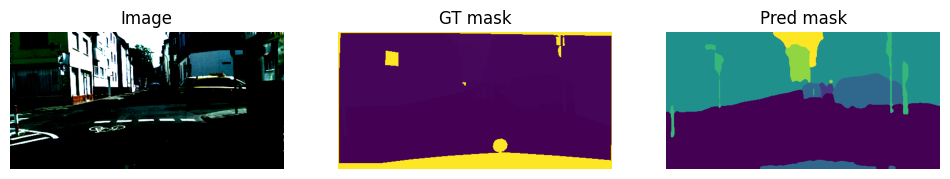

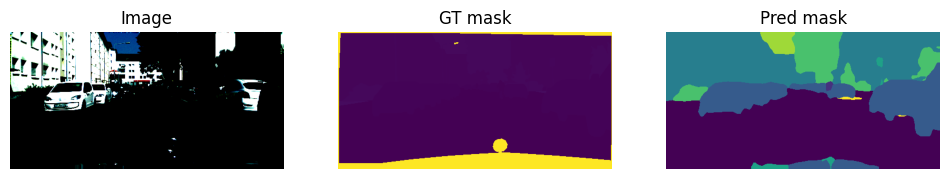

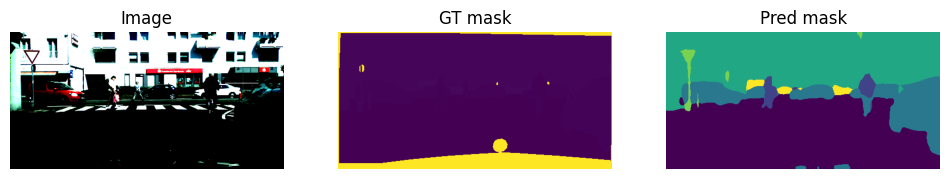

In [ ]:
best_miou, best_cfg, best_state = best

model = build_model(aux_loss=best_cfg["aux_loss"]).to(DEVICE)
model.load_state_dict(best_state)

fixed_train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

best_final_miou = train_full_deeplab(
    model,
    fixed_train_dl,
    val_dl,
    cfg=best_cfg,
    run_name="deeplab_best_hparams"
)

# Après l'entraînement
model = make_model_deeplab(aux_loss=True).to(DEVICE)

# Charger les meilleurs poids
model.load_state_dict(torch.load("deeplab_best_model.pt", map_location="cpu"))

# Basculer en évaluation
model.eval()

# Export propre
torch.save(model.state_dict(), "deeplab_state_dict_final.pth")
print("✔️ Export correct → deeplab_state_dict_final.pth")


def export_torchscript(model, out="deeplab_torchscript.pt"):
    model.eval()
    example = torch.randn(1, 3, 256, 256).to(DEVICE)
    traced = torch.jit.trace(model, example, strict=False)
    traced.save(out)
    return out

ts = export_torchscript(model)

mlflow.log_artifact(ts)

def show_val_examples_deeplab(model, val_dl, num_examples=3):
    """
    Visualize DeepLab predictions on samples from the validation loader.

    This function displays side-by-side:
        - the input image,
        - the ground truth mask,
        - the predicted segmentation mask.

    It iterates over the validation dataloader, extracts images and labels,
    runs inference in evaluation mode, converts tensors to NumPy arrays, and
    displays 'num_examples' triplets.

    Args:
        model (nn.Module): Trained DeepLab model.
        val_dl (DataLoader): Validation dataloader.
        num_examples (int): Number of examples to display.
    """
    model.eval()
    shown = 0

    for x, y in val_dl:
        x = x.to(DEVICE).float()
        with torch.no_grad():
            out = model(x)["out"].argmax(1).cpu()

        imgs = x.cpu().permute(0, 2, 3, 1)
        gts = y

        for i in range(len(imgs)):
            if shown >= num_examples:
                return

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(imgs[i])
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(gts[i])
            plt.title("GT mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(out[i])
            plt.title("Pred mask")
            plt.axis("off")

            plt.show()
            shown += 1


show_val_examples_deeplab(model, val_dl, num_examples=3)


In [ ]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 8  # Cityscapes -> 8 classes

def make_model_deeplab(aux_loss=True):
    """
    Reconstruit le DeepLabv3 utilisé dans l'entraînement.
    """
    weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
    model = deeplabv3_resnet50(weights=weights, aux_loss=aux_loss)

    # Replace main head
    in_ch_main = model.classifier[4].in_channels
    model.classifier[4] = nn.Conv2d(in_ch_main, NUM_CLASSES, kernel_size=1)

    # Replace aux head
    if aux_loss:
        in_ch_aux = model.aux_classifier[4].in_channels
        model.aux_classifier[4] = nn.Conv2d(in_ch_aux, NUM_CLASSES, kernel_size=1)

    return model


In [ ]:
# Charge le fichier que tu as (qui est cassé en TorchScript)
bad_path = "deeplab_torchscript.pt"

try:
    state = torch.load(bad_path, map_location="cpu", weights_only=False)
    print("Fichier chargé (probablement un state_dict).")
except Exception as e:
    print("ERREUR de load_state_dict :", e)


/usr/local/lib/python3.12/dist-packages/torch/serialization.py:1493: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


Fichier chargé (probablement un state_dict).


In [ ]:
ts_model = torch.jit.load("deeplab_torchscript.pt", map_location="cpu")
ts_model.eval()

print("TorchScript rechargé :", ts_model)



TorchScript rechargé : RecursiveScriptModule(
  original_name=DeepLabV3
  (backbone): RecursiveScriptModule(
    original_name=IntermediateLayerGetter
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Bottleneck
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
        (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (downsample): RecursiveScriptModule(
   

In [ ]:
example = torch.randn(1, 3, 256, 256)

clean_ts = torch.jit.trace(ts_model, example)
clean_ts.save("deeplab_clean_torchscript.pt")

print("TorchScript propre exporté !")


/usr/local/lib/python3.12/dist-packages/torch/jit/_trace.py:685: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(


TorchScript propre exporté !


In [ ]:
import torch
ts_model = torch.jit.load("deeplab_clean_torchscript.pt", map_location="cpu")
ts_model.eval()
print("TorchScript propre chargé :", ts_model)


TorchScript propre chargé : RecursiveScriptModule(
  original_name=DeepLabV3
  (backbone): RecursiveScriptModule(
    original_name=IntermediateLayerGetter
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Bottleneck
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
        (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (downsample): RecursiveScriptModule

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

NUM_CLASSES = 8  # Cityscapes 8 classes

def make_model_deeplab(aux_loss=True):
    weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
    model = deeplabv3_resnet50(weights=weights, aux_loss=aux_loss)

    # Remplacement des têtes
    in_ch_main = model.classifier[4].in_channels
    model.classifier[4] = nn.Conv2d(in_ch_main, NUM_CLASSES, kernel_size=1)

    if aux_loss:
        in_ch_aux = model.aux_classifier[4].in_channels
        model.aux_classifier[4] = nn.Conv2d(in_ch_aux, NUM_CLASSES, kernel_size=1)

    return model


In [ ]:
model_rebuilt = make_model_deeplab(aux_loss=True).to("cpu")

with torch.no_grad():
    for p_rebuilt, p_ts in zip(model_rebuilt.parameters(), ts_model.parameters()):
        p_rebuilt.copy_(p_ts)

print("✔️ Copie des poids TorchScript → modèle PyTorch OK")


✔️ Copie des poids TorchScript → modèle PyTorch OK


In [ ]:
torch.save(model_rebuilt.state_dict(), "deeplab_state_dict.pth")
print("✔️ Export terminé → deeplab_state_dict.pth")


✔️ Export terminé → deeplab_state_dict.pth


{'deeplab_png': '',
 'mask2former_png': ''}
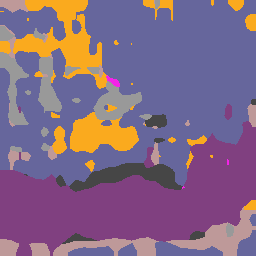
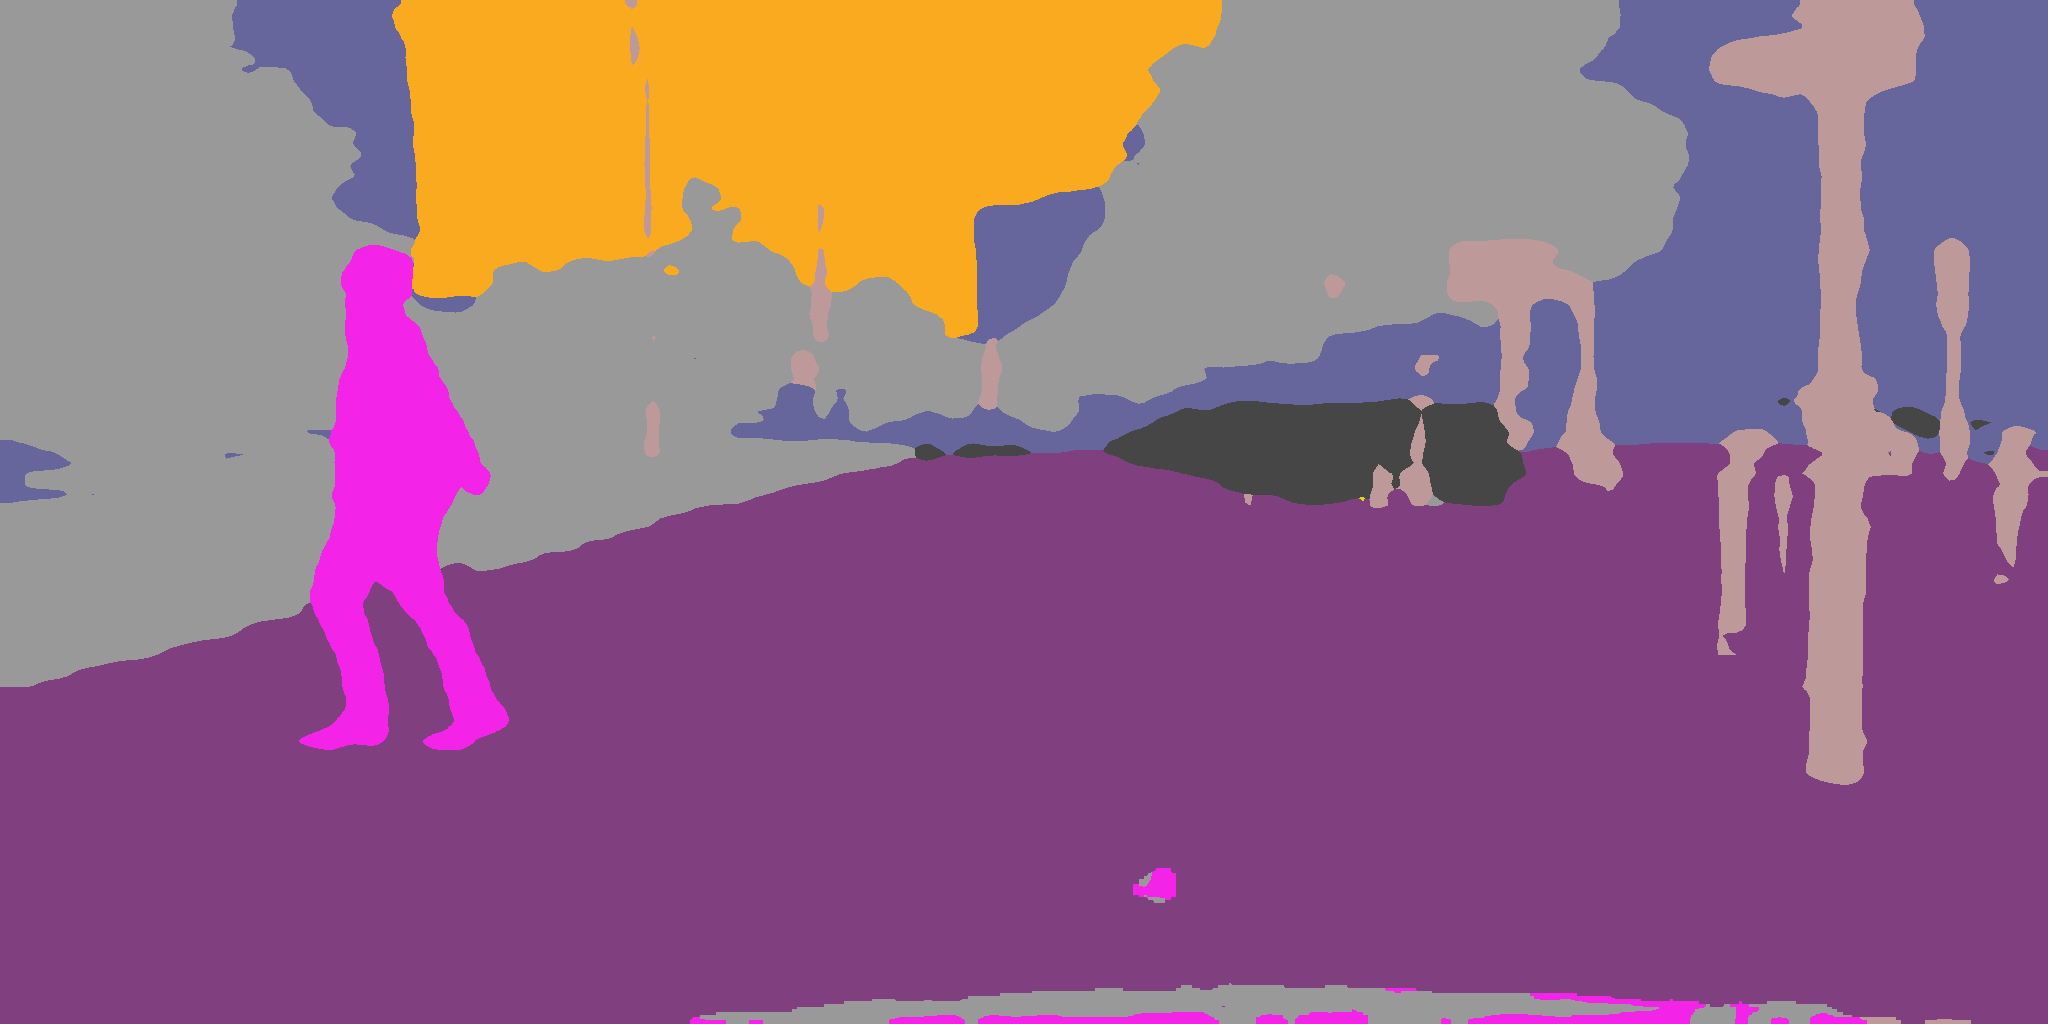

In [ ]:
{
  "deeplab_png": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAIAAADTED8xAAASKUlEQVR4nO2dz2tdxxXHr6SH915KpEWbl3/gQRcmiEK17M4QnpYuxYTwViWE1AITDE67CF09SgUhhkCwCCQQyNLJwggtCtoXi4Agxl5qb3hQ6olvx/fH3PlxZubMme8HY2T5vvvuvfP9zpk5M3dm66eTk4aI924+bIpl9eR+w5714QPzAWfXx5dv/+aOXaGskt9+ey/2Xz15+x1szrztdEYAhAEDgKqBAUDVwACiKLoblqWjQmmAs+vjpkyK6AEXdJ329+J6R/bHWx7JIgKsntyXVLR8npVlCigXfoVOK5Wtu3e/aP+xXGzSR2HD/bimvfwo3Xudp/ToTRx2Uv+qtIdg1ob97cz0f5xe7FDZwBLzha6e3E/jgaLRn2HncZkf77rkZ2vQhpOZ34oAOpM2MLjFMghYXmjUciqu5qMdYFq7j0axoq8N1xsZNYDBA0r65oPNHnC9ykgeKLTUbZ6V6/DqqthHEejhrVff/Lb9x+ApdGUPSr9/8ORhHlB5oNyStqQ2AwQym7zz04ud5WJjqekY0g/vD1RbuoAmDRpP1gDk5a0sUA3oYQSRoTb6jYhaDFB0yg/EEwCLkeBcwBWVYCjoqg0gFTTt7Ks5egOsDx8gbQ9KQX4EwHyKmllPFX1hBnCaDdtOnKwqdMSbYCwS+ixQ7AdqmPs1+SmEgkFWFXugsAjQAbUdqNoAAARWedUZAEEA6Mw605gx7QdUxayzkJj9xE8ABNBtAl2mfSXSAAbUQILiHu4DxPDAYrFZRDith5qRDAUmA6hGUd44kEyjMEPla8kMR4DWA0yaQwCEM+iB0ZHgy6aZ03WL28bPYrG5SNLJXh8+GLxhVPk1s+pJwjQO0CaIaOPAZE8gnkYHzwxL1MzEQFg8D7Q20BtafpmfseZd51QQOvCZDKc8MLduC/V11i7WZwgFkToblqIfay8B8dhOhbjUooEBj1pWP3PG9aXjDTsAzlDOBRoTkM0qrWPuSixKeKA2bA0wf9MK8pPOpAdUxsnjzFAtiP5CzJxCf7oHxnoFHhuc0KofPYHamLlKn0RwrRmUE+a+61ei7gexmkCqzRObOzcfzq2rf13u/Pus/K8Q/C8CjLXOBxMy2fdgK0VSpVwnGI0AybSuvii7tSLV6HBCwVmgjijjabQI9Xd+8PgsyWGAlureCQ6fUuF6KmSWOFPL6tDpwZItRYAIAKoGBgBVs11WPxV7yoOkBmCi+4704QFQUScYcgfsDJBmWo5B+lj1H5Aw0ydm9qdFDE6IGNRlZ9Xy8Jw6Kn6Qug/w6PpY/emrv/3ZRpfmmjvgamOdSoFX5itkuBOs26Dl7PqYRHOWJ+GwJBHULx6mnWDLl4PJewJQfG1YrQtEjiEInF0fZ3w1HtTG1snJifkI/bUY2pXTDStktV/qtxBLVNA7r3FdIJsXFwnXh2sXIwKAy1ygS4tVDS2xPI9lGwxVMvAGk+FA1cAAoGqcDRBjlxcAcoEIAKrGxwAIAqD2CMDKA2nGATBCJxL/qRDJNjuyxDytlQp4QBhBc4FUHMhug/68vbHFd8e8YTi+BaNyItm+uNjR/zTSsdF6yt2iAK8IcHGx49q+59YWGsTcKLpz86G3MYC0TnACNdt/RXgH987NhzZdgpAtPIC0LJCrB5yCRrJ1wy2lrx8f83JAUWnQGB7QpU+ltpCNybw/hfdmxLAdafdfG9FEUptrxd//uM1h8ID8NKhHh9g1NzqnfgdtUL5O86XXhw8GT9IfAcDuwgJINBdorL7srDw3d/y4+n2r13D126y+qF/z+vDBP378o9P5QY0G8Ksp7Vsyg82ekIVELT/46q//bpoGHiiXrbt3vzD8t0cTyKn3bDi/LmizHAfjA0njpHPms+vjTshSBlD85Q8/hH8jKGkqRJrxr0kpqwNascZrl/eXCr7xt9+1HmjjAJwg3wAk0qedUsqnP6q3iGAGgX2AlBMf8so6/NvRPZBmAP7TfhLz9cfff/3x94YD4AHO4JXIRDYAEgyQuPHDp1k/RmcO6ZgHbIJAsilSQAcRgBjEgbLYdsrSsHoVOA0eUcjPA0VEPHlkiwCTXirabOgSSBgJHpQgVTfAUt9Mkk791rmqrcu6C+AwEDZWtEW8AElOuxMHWinCYLpDDEO/DUrfb8Y4kNwHML8WIw8m/gSUBvBTsC59QhvwtxM8UC4YB2Cd0VL1CP8qoPZVIVw/5bH0UMMSe3V63DLbu5YEcSdY7xTKbhj4vS1teCaQu5AskGzdByo1pC0k/sGWsS5QrmJgUkEyuQxABTrBDkD98sgwEJayGdD5rpDwBfWLhPtIsLcHBvXq3ZKG+iVxdfWNVRNIZK8LUq6cK039efoAgb4KnIDp8e0cPCOyMqq3E5zMA50vKlRGhV528X2A5WITvlrtGMnmUaYxWyQg/dhgp/hQAldjH6OSLdvs2Xv2XP1pAlguNp/cvm37RthYBCAsmBA7JdCH+fLaC9DfFwvfa+zOzYd47aaPLv0X777TuDO4u6F/GnTv2XO/6yjlhRJL9Xdoo4GHE9Rnof4+nYrfQ3tje3v6dIIXi426oMB4pJAa6LFDWRFgKsQwieNSq35U/33C61nD1s6lGiB23Jg8/6RDHl0fW7aCpMZAPpyOP2FTH8CQA9092n35+GVTN4vFZrDd4tH6R8Vf6lwgqnnq5pMQzmmj7aA/uj4O6fWi+pcwGS7Suxr6OjyJVdKmNW007Z33hPSLXBirZfdol+oiDFJIvBxVmvWZIX1p06Fjv7CXxgZFqL9fMdmcUE2B3N9/P+SrRVLS+wDxtsEbk/6dmw/DR3bDMUdj9b/ffvutSBvsUYw1qUTQYDK01DRooRQ6GTsj4bMNzJAZgLyc0rT7J/dlIRyg9TuVzaw4m+pfEi/oXDHjPEsnqgdS7kcUPslHeWCwRMSr/8W774TPhCPbH6Dc/Eag4r0nt5GbuS0Xb+mX1Q1QKA+EqN95NujcOBhcClQ1fb8B09F0spCSt8pfvpaRYXJBWZ2BiT7A3PF02VtNaRjcz8tQx2OmA9s3aaLsD9CwIUatnFfNhomN4r89UPdPh2avmQygwty82DiQXv2xvcFH/UseRexK3wO2EWAupSssgB/+/J/clyBn+GxmP342z9H14YZhUkaCTrB6/u8dBp3EOwV0qomhXCU8ffzyQJvGZkqDtiwXGyY37DQbImWmfxLzBXvM8uiscNY0jb7ewd9HMkUlJkDJg4CzAaKiOgw2raaOoCe1wsoAgxc8doUefYl+o7z1QD2i92gFcZkMN2mDvlbWhw/KSi9GNaQK0XoTpU7du5J5MlwnXzSWPhqTDrc6ngrv+zq92FF/qK9ILDkNQJItleoBkAZ206H7rvCTeOnGKP36S4GdAQCo2gAkg2ioPqt62yvkzNustI4h5HrYi6b+siMAEBbH1sa7iGEDp3NmNkBb5Rte/HNN9svQjQzWr8uiXyK6RvOGgvwDYYHNnrLGwhiyjrPkTEf0+qhlVMW7njy/AYABj9Hu/hwhRX9geK1plNYGg0FY3cugQEn2mvCjDAOsntxHwyZE/f1FgQwabYzoH7Sf3TRZPZN4wCO2lGEAwJM1aa0U/tq72CyQ4UHLjgyETfP9/ff1VtDgmVcxO1Sf/fNPUTfD8+taFBABZEvcgIcc9/ffXy42+ssAhjmhq9fnd239+zVHLdU/KOioMWHGZ/LPYDrI5lkXNy/ahpA7Um/GWM4JXcV/dB7qN1ftfUt4Z5byGyDZEtPhGLRCG6a8RZnmXfXVUBAIVLkTnYXiQvKqM4bvAwzuv5sdm/UgSC64iGi20u43pfT7BI4qzJw0mqaGXiw2rguxMGkFhadrOdyFPWN5/YKYBb6xFWKJyRdizq6P3+Oxe27sPqIfHfElTiDuFS59mjQokzWwWOFXiw8ut+ikPxmKTAyv6dCKeZjmXJU0eWaPs7l+pKyWjyQmlkVRWYXLhJte9dU/2QoaU094U4REl4bLCDl/v77Xl7tJsHbVnoiAY5UF0kVJvmB6xz9zxzbV5JrM5rkrtIvzRD2PK7GXM7v34Zd58z/RDTCYVFZmuGwatVP87tFu/zDa527oCttoa/KY9oBJq3DmdQ8Y/bFU4wDzpnk53l4nr3v6Hogh0OJEr5NlueZ75QeBWaQHGsMDWO+JT/W/5jRGyTQLVOgS8sXx4t13xh51Apne+/BLv0+pP01uypgODbyzMWw9wISIBvBrsaCdQwjtkMgYHt0APj0HRrNBDbvawxXycvCf8fDAaASw1NzYYYGSbT+OtY4ZstaaVcl0/NEvH7CIAP+X45upV+1vaHu9WXTvsVMLh+q/s+2PVD765YPPf/OvnAYwi7LoqrqUvF72xs86R/Ufj+ltUsf+KYnB7WeaohjcBBcU2Qnms95EvIaQYQEfM3vNrbH/StAQWsuq/mGApHiL3oPBXSKxa5jndGjZTaDYs0HJpX/r1WgQaJrm/Ma5+eOBNlgzeA84QwSQqv6oLzGmrPJtpD+4RmLloAlE4IH0QteDgKXuO8AGChjA3wOJda/jJ/o+V1ffeHhATPvHoQ8guAnkOhCWUffx2HexQfaxCEJm5pt5+uzXH/Ze/51rEXcmiJR+5Wx9+vtPPT4m2Alt+r82ue9bBwFJEcDTALKdUJv0nTwgSf0E7wP4LeXOmWrVXyc0WaC9Z8/bvARVZi3LvlFQf22QpUFVZvr8xrlfZq2DiiqDHoiXwM6u/rEhXqqkJ4g+DvBrEYZt9tTZRFY/T6tREpvxwTy7oa1cEl5RLUQcCPPY4sa8h2anhqb1QJbq36z7/sHwQJEjwZa7/5n30Ixa9unV7yR9/VPwQKlTIQb1rVzhnUciCQKJ1e8nff3j8ICcuUAJUqi6vrN3GwLV3z9JYjPsyUp55zdAOOYg0O82qB/aj6Sp/kl0b39mhIh0I8EpGSvXMQOwTWsmwNsD++O1ibzqX0IEGAsCMdSfUdCueGdOr2Tll0WtDWqvP3L133p1qyD1t/hd89XQ0xNZ/ZcXAcZyIHqmNeULuPzxyxpd9TpLUimpD9CiSjR2/6906RM+me9+/op8STYmFGkAM+EeECb9wCfz3c9fqR9EeqCwJlBUpOo+fADhc4nSFxsB7AtYvOLDn9gt6Y9IbAQwdP7EF6oft6p8LGIN0MmF11m6oGoDKCB9IGQgDAByYABQNTAAqBoYAFQNDACqBgYAVQMDgKqRPw4AgM69D7/U/4kIAOpVPwwAqlY/DACqVj8MAKpWPwwAqlY/skCgXukrEAGATA6Odm0OgwFAveqHAUDtoA8AxFb/Z9fHkwcjAoBKGz8KGABUDQwAqgZ9AFAdpxc77c+IAKBe9cMAoHZgAFBv9Q8DAGk8ffzS6XgYANRb/cMAoKKBsOVi0/8lDACqBgYAcuY4TB7TDwIYCAN86Qh692h37t7NNQMDAHYMVuSXb/4es4HlNLjlYqP3hmEAUMzMzZbLN59tbeB9KrGb5AHmHLhIVlX/HeYUl4FOMMiAd4U96QpXYABQpPqpgAFAvepHJxjUqH5kgQA9529vS97fnZaJ+jvAAIBY+oO//OT27YYl8vsA5zfOB0sIkJDm2c7p0qCdOaGzSoqn/QEbxxNyXn7Nsl1bxS+gzJhwXuCT7L8SMKuwbNT/IhSUC8kYsFgDWNZMRTeK2owK7dTIGFB1f+cRXgeTZgC/oNz/VIgl+sm+QI2as4edOWF8+IRN2mdM+oqtn05O+r9l+EDTN0knbRCY2DY/ZL+TJyu486GnzUf0k7qfMEBxfojaIWudEHUo5+njl1TndyqvA5bjUwmk72AA5jYYUz+rCim7FPaePZeqeG/1uxmAoQ34B2K2IhhcIqE29ft0gp3yD/aVjYevdPULEL0qvHBdWoqgPWwp0Qn2xMoCucZZ12zGwdHuQVO86L3rLfJvX5ZvA7/HGGskOGpLSUwr9vRip1Nsucxw+vpK8loxC7zGAQ6Odiedw0r93g0JtlI7TRUQmEQe506wUwXvIVbDmWmlb69dS7FalmXsHiqhtZbR1Nm5SJIv8rtxXhHAQLj6xx4QlWJOL3bMBZmm1u+sexPC6ch5vPVqLoIs0cAnAjh1Vd0vyX/NIw4tjbFSdL0SJkEg8e2TWytzBCAZ3fQ7Q8beZL8UPS5mMp7w5DTssacPBRzfBwj0TPZsBpPETrmcJixBZwMkHgl2MkN26QNC0hQlxwgAQDJgAFA1MABoaua/a9T0PtCB8V0AAAAASUVORK5CYII=",
  "mask2former_png": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAACAAAAAQACAIAAAD6ZS4TAABfVUlEQVR4nO3dT4tcV7ov6LRSnLmHKtqgifoLBNyBMaKgTY8aNBAUKdQTw+FgLhpdjDAIhDGYNsL0yBxsOKDJEUoKNBDc0UV3kogaXMgvUJoIXHQONS9IaOyoioqKzIzcsWOvvd71ruchOcclpTJ37B0ZGfv3W38++vnnnw+gcaenh7UPgZn8+Pm3tQ8BrvT2w5NrP+ezj7+b5VgAYCbPB/z6A6hIYsAWR4vz2oeQ0LEfumBu1D4AAAAAAABgegoAAAAAAABISAEAAAAAAAAJKQCAZtgAgOCs7w8AAACEogAA2iD9J0EHoCEAAAAIwg7AhTix0SgAaN6pvcU7IP2nIVJ+AAAAIIibtQ8A9iL9T0/0T9MdwNsPTzb+BAAAgLoMUS/taHF+LLILwwwAIC7pPzlI/wEAoJaFqJd/Jv2fh/MchxkANMzw/9yk/yQg+gcAAAAqMgMAAAAAAMjPsPQ5OdtBKACAiAz/BwAAACYkj6ZPCgBaZf0fAAAAAAhL6RKBAgAAAIAxnn94UvsQAGAQSTTdUgDQJMP/c7P+DwAAAFNZSH67J/2nZwoAAAAAAACmp32pTgEAAAAAQFpWEQB6pgAAAAAAANI6VgJVZRJAXQoAIJxHb57WPgQAAAAgDx0A3VIAAAAAAADJ6QDokwIAiMgkAACA4J5/eFL7EABgN8enh2qAKqwCVJECgCYtvGoAAAAAsDsdAF1RAAAAAAAAHdEBzM8kgFoUAAAAAOzG+j8AtM5yQHRCAQAEZRsAAAAAoCgdAOkpAAAAANiB4f8AwAhWAapCAQAAAAAAAAkpAACgoLfGSAKQi+H/AAANUQAAcdkGgNZJ/wEAoK5TK7yzlUVpSO9m7QMAgOTefnjy2cff1T4KAADojvSfq8j96YcCgFYtFud+kffg0ZunP37+be2jAADgV9b/ARoiNGCD0J8+WQIIiM5CQCRgLSAAAJiT9J+Vo8X58qP2gUAdZgAADTAPAAAAABhI3A8rCgAAmIOdAAAAYB6G/3dI4g9XUQAAbTAJAAAAgGtJ/zsh8W/U0eL82A/pvBQANMw+wEBb6/6bBABA0+wADAQnIkhJ0A97UgAAzTAJAAAAgItE/00T8UNRCgAAAACuYfg/EJb0vzkS/55Z/2d+CgAAmI9VgABokfQfCEv6H5+4H+pSAAAtsQoQAAAAxCTrZzvD/6tQAACN0QEAAMzJ8H8AriLxh/hu1D4AGM9Ev249evO09iEAAHRB+g9EJhao5WhxvvyofSC0xPD/WswAAIBZ2QYAAABokcSf0aT/FSkAaJWeHwAAijL8H4hMLDAn0T/7kP7XpQAAmmQnAACAa8P6L8w5A2A/on9onQKAJun5AQDg2kH6G3+7Ux9g+D9A50T/TMLw/+oUADRG9A8AAOMC+vV/sqUMEP0D8QkHihL9QyYKABqz+O2XkN/0QNPsAwzAPiYJ6FdfZL0JEP0DTZAJlCP6Z1qG/0egAKDhGsBv/c7ZBgAA6E2JgF7oD8CS9B9SUgDQNk0AAACdkNQDuP0vRPRPCYb/B6EAIFsTsOQNARCZ9X8A2JX0H8CdPsAICgByMjMAAIAcRP8AFGX4P+R2o/YBQFmLxfnG5ACAeRjmD8D+pP8AS4b3FSL9h/QUAHRBBwAAQHOk/wBL0v9CpP+UYwOAOCwBRF8dgDcNAADEJ/oHWHEjX4j0HzphBgB9MRUAqM7SQABsJ/0HoDTpP/RDAUB3dAAAAIQl/QdYZ/g/wJ4sAUSPFotz7yES+PHzb2sfAgDAZET/ABvcuRdi+D90xQwAOmUeQAKP3jytfQiwM+v/AHAp6T/ABuk/wCTMAAAAAKhG9A9wkfQfYCpmAAAAANQh/Qe4SPoPMCEzAABgJtb/AWCd9B9gg+h/BjYAgN6YAQAAcyT+0n8A1kn/Adadnh5K/wFKMAOATnljAQBAFaJ/gHVuzwGKUgDQI28vgDkZ+w/AivQfYMW9OcAMFAB0wbsKoBbpPwAAXOQ+HWAe9gAgOcsI5vbozdPahwAAMJTh/wBL7tNrsQMwdMgMAHLa9c3EYuyvQO9aAAC4lugfYMlNNMDMFAAkNFv6v+Xfek8DAAAA69wpA8zPEkB0bbE43yf93/6VS3xZAACaY/g/AAC1KADoV+mMvly7AAAAAABwLQUACV2bvM8ZzesAAAA698XH39U+BAD41bFVmKA/9gAgrVXyvlpksFYWv1icW+gQAAAAAJiZGQDktxzvbyQ+AAC1mAQAYIp8ECYBQG8UADAH73IAADqnAwBwdwwwPwUAAAAAADPRAVRnEgB0RQEAAAAwB5MAAJZ0AJCbkikUBQDMxPsbAAAAWHKPDDAPBQAAAAAAc9MBVGSANvRDAQAAUbz98KT2IQBQllWAANYtFufLj9oH0iMdAHTiZu0DgI4sFuenfr8CAADAP7vYAbh9hkbplqJRAABACIb/A3Tii4+/e+41H+A626cFqAcmcXx6eGT6BZOS/gf00c8//1z7GKAv3qZM7sfPv619CDBZAfCZpSEA+qADACjBHfc4agD2J/oPywwAmJuFgAAAMA8AoPS8Abfeu0a3agBGkPvHpwCACnQAwFXefnhiEgBAJ3QAADOUAe6+xyW5ygC2k/s3RAEAAPXZAAAAAEpQA0wb7yoGOif3b5E9AKAa7z8mZBsAMhUAZgAAdMUkAIDZuA0vSjeQldC/dWYAQDUWAgIAwEJAALNxG16UFYSSkfunoQCAmrz5AABABwAwG7fhVbJjfUArhP4pKQAAAAAA6IUOoGKsrAmISe6f243aBwC9W+5HxJ4evXla+xAAAABogzvxWo5PD5cftQ+EX7kcnTADAOoz+gAAAADm5E68LnMCKpL490YBACF45wEAAABzcicega2D5yT675MCAKLwzgN69tnH3721/SNAr+wADFCLO/Hg8bRKYCqi/54pACAQ7zwAAHoj/Qeoy514Q7H1tH3A8oun7xhE/ygAIBbvPAAAAGBO7sQ72Tng0ig8cQ0g+mdJAQDheOcBANAJw/8BgnAn3pbhqf3AEDxfDSD9Z0UBABF55wEAAABzcieeY4GgfYLv49PDBB2A6J8NNzb/AIhh0f6vHGAnn338Xe1DAGBWhv8DRONOvGnHp4f7Z9+tp+etHz8lKAAgLu88dvLozdPahwATUAMAdEL6DxDTYnHuZrxz7Wbo7R45RSkAAAAAAGCzBtAEdKvFJL3FY2YeCgAIzbsNAIB8DP8HaIUmoFtt5eltHS0zswkwAADAfKT/AC1a7wDsFUwo0n+2MwMAojPQALryVioEkJr0HyAB0wI6IVgnBwUAAAAAAOxMDZCeDoAEFAAAEIKx/wDpGf4PkJIaIDcdAK1TAEADvJMAAGid9B8gNzVAYpE7gMjHRhAKAAAAgLKk/wCd0AEA0SgAAAAACpL+A3RFB5CSgfa0SwEAAABQivQfoEOWAwLiUAAAAAAUIf0H6JkOIBmTAGiUAgDa4H0DAEBbpP8AmAqQjA6AFikAoBneNAAAtEL6D8CKGgCoSAEALfGOAQAgPuk/ABepAZicGQkMoQCAxni7sMWjN09rHwIA0DvpPwBbqAFaJ3OnOQoAaI/3CgAAANB6DeDuHpiBAgCa5I0CAEBAhv8DsBN390BpCgBomHcJAAAA0DoTAoByFADQNu8PNtgGAACoxfB/APakBgAmpwCA5nlzAABQnfQfgKm4zQcmpACADLw5AACoSPoPwLTc5gNTUQBAEt4crFgFCAAAgNa5zQcmoQCAPLw5AACYn+H/ABTiNh/YnwIAUvHmAAAAAABYUgBANjoAAIDZGP4PQFHu8YE9KQAgocXi3FsEAIAZnJ4eLj9qHwgAabnBB/Zxc69/DbTwFsEdKQBACY/ePK19CAAAsI0CAPLbabCAtgAAYET6f3p6aIQmAADRWAIIuGT5ILevAAC7jv03kAKAQtykA6MpAIDLeXsBAHApK/8AANAKBQBwJVMBAAB2YhIAAIW4PQfGsQcAcI3F4tytLACAsf8AADTHDADgegYaAAAMTP+NnACgEPfmwAgKAAAAgGsY+w8AQIsUAAAAAFOm/yYBAAAQhAIAAAAAAAASUgAA2Uax/fj5t7UPAQAAALq+N2cGR7aFYAAFAADU9/bDk9qHAMDlrP4PAEC7FAAAEIsyAAAAAJiEAgC4hjmGAEC3Rg//9w4KgGn5zQKMowAAAAAAAICEFADANoYYAADdsvo/ABCcfYC5lgIAAABgk/QfAIAEFAAAAAAAAJCQAgDYZmEqGQAAAAC0SQEAAAAwMaMoACCrY9sl0hQFAHANt68AAAAA0CIFAHA9HQAA0JsfP/929L/13gkAmIfpCFxLAQBku4999OZp7UMAAPrV0LsmAADSUwAAQ7mbBQC6MmISgPdLABTiVwwwjgIA2IE3HAAAV/FOCQCAaBQAwG7c2QIA/dhnJwAAmJb7cTbYAIAhFADAzrznAADY4A0SAAABKQCAhOwDDADMNglgsTiX/gMAEJMCAAAAYCTRPwBz8nuHFev/MJACAAAAYAwpDAAAwSkAAAAAdib9BwBqMfyf4RQAwM5O/ZoBALphbyEAANqlAAB2I/0HAAAAgCYoAIAdSP8BgK5cNfzf+j8AQC3W/2EnN3f7dKBXon8AoDeXpv+ifwAAGqIAAK4n/QcAuvL8wxNZPwAACVgCCNjm9PSw0fTffn005O1vMRMAodJ/AAio0Tt0oCIFAHAlbywAgN6MSP/bHTABAEB6lgACLuc+FgDoyuiB/4vFuTdOAADEZAYAAFT22cff1T4EgN7tueyP3QIAAIhJAQBcwig2AKAfFv0HoAlu1YERFADAJYxiAwA6If0HoAnSf2AcBQAAANAp6T8AMMKxPoZ2KACAy5kEAAAAABEY/g+MpgAAAAB6ZPg/AADpKQCAK5kEAAAAAHUZ/s+GI3ENu1AAAAAA3TH8HwDYh20AaIUCANjGJAAAIB/pPwCtMPwf2JMCALiGDgAAAADmJ/0H9qcAAK7hDQcAkInh/wAA9EMBAAAAAACxGI0Xn20AaIICANjGGw7omUGyAAAA0LSbtQ8ACEr0D33aCP2X//OLj7+rd0QAU1JtAtAEt+RNOLJpIi1QAACbvM+Abl2Vi6kBAAAAoEUKAOAfRP/Qs2tHxaoBgNYZ/g9AE9ybAxNSAAC/8vYCOjc8FFMDAI2S/gPQBLfnwLRsAgykfXvx6M3T2ocAaT3/8ESUBjTESxYATch6e860jj1P2IUZANA17y2AfXKx1T80IQAIS/QPQBPcngOFKACgX95eAFPRBAAxSf8BaILbc6AcBQB0ytsLoEQ6ZocAIAjRPwAA2AMAOiX9B4qSuwEV2aQEAABWzACA7kj/gZVyGZmpAMCcHr15uvrvxeK86rEAwG7cpANFmQEAffHGAmL6rEZQPsMIWYNwgaIevXm6/Fj/Q+92AGiL6pqdHHurw47MAICO9HY//OPn39Y+BODXDsA8AGASG0E/AKSxWJz3dsMOzEYBAADhvP3wpMqcAIAcKf/p6aHRlAAAoACAjhhNAABEY1A/ACyZBAAUogAAgB7NuTq/VYCgQ9WTfZMAAGiODgAoQQEAXfAeAgBIH/oDQOt0AMDkFACQn3cPAEAhQn8AmJYOAJiWAgAAKM4qQJBME7m/VYAAAEABAMkZOAAA9Bb9A0DTTAIAJqQAAAAAriH3BwCAFikAAACAnNG/VYAAAOicAgAAuvP8w5PahwA0oOnoHwAAUABAfpYOBCKwAzA0RO4PAABp3Kh9AEBxZr5DfG9TD8mX/kMrHr15mi/9NxICgOb45cUWR0IedmQGAABQkPQfgsuX+AMAACsKAOiChYCAKqT/EJDEHwAA+qEAANJ69Obpj59/W/sooFOi/3HefnjymVNHAUJ/AGiF0XvAtBQA0AuTAIDZSP/32QpCB4C8HgAAmIoCAAAiajQFFv33fPUZTdwPAAAUogCAjpgEAAT0/Ldh7xd13iXoAHog9wcANrhnByanAIC+6ACAZbZ+Vew+m2sPYPkJPdcAOoDERP8AAMA8FADQHR0AUNdO3cPzD0967gDIR/QPAJDD0eK89iHAIAoA6NHit99SagCIrNGh36twfyO1rz7hACKQ/gMAW7hJB0pQAEC/TAWAnpVeBUjiDxuk/wAATOJocX4sz2GwG8M/Fcg6FQDoUytL6+gSSED6DwBsZ3weUIgCAHq3WJyrAaBbrXQAAAAAwAgKAOBXOgDolg4ASjP8HwCAadmCmOEUAMDf6ACglre1l7jRAQAAQEXW/wHKUQAA/6ADAIBpGf4PAABUpAAA/okOAPpkEgAAAFRh+D/jWAWIgRQAwCbbAgPAJAz/BwAA6lIAAJlrAMkLDGcSQDSfuSIwhQTvZwAAYLSb4/8p0NM9szmJAAAAANAWBQAwcvScSgDy+eLj755/eHIQjKkJAAAAMI4CABhJJQDMQPoP7MP6PwAAdM4eAMDE2wZE2zzANgDQLuk/AAAQ07FBkDRCAQAUEa0GAJrL3OMcSRV2AIb9eSsCAACWAAIKsocwME7n6T8AAABMwgwAIP8QPKsAQVuk/8D+DP8HAAAFADAfiwIBDGT9H9iTtxwAALCkAABmpQYAtjP8H9iTdxoAALCiAAAqcGcOXEr6D+zJewwAAFinAADqMBUA4FLW/4HRvLUAoDmnp4e1DwFITgEA1KQGgGiB7/MPT2ofQr9CPROgLd5RAADApRQAQP6b9h8//7bcF4dMpP/V6QBgV6J/AKBbR94FMcDNIZ8EMIP1u3ezIGF+0n+gOaJ/AJrmzheYgRkAQNzRfKuPfb6U4f+0OO67z2HgdgAGdiL9BwAwCYBrmQEANHmHb6AETMvwf6Ahon8AEnBX2zrJO60wAwBo0sDJAYb/05CKo/6l/wAAMCfpPzAbMwCAtq06gIvvn6T/NGrOJkD0DzTH8H8AABhOAQDkbwKgFaJ/gO2k/wAb7hwcvKt9DOzKTSvTOlqcH3f5pLq4ClOf5+FaCgAgm8Xi/PT00PB/2EL6DwAQxJ1iX0ExEJP0H8ptwLD8czXABgUAkJDhgdBi9P/8w5Mv6m2EAMTn9zvQW7Jf4gC0AkD6vZfVABsUAACQX+Tc/+Jx7lQDXPrQFAmQj/QfSJ/XV3mY+oCZGf5PIZ2sAjQk/d/45OMOTsu1FAAAkFkr0f+lx7zM8Uc8hI2vAADQee5/7cPXBABpov+Nf3jcfQfw0c8//1z7GAAmJvKDFnP/QrwgUNejN09rH0IGhv8DJXQe/V9FE1CO4f+ZjM6jy0kcc+9/to/znpwhzAAAgDzk/hfZWgAAuEj6v/3MqAGATF3LUd/zABQAwGQePrt37ee8ePy69GFI+uiN0L/E1gJAHIb/A9MS/Q+hBpic4f+Uli/jnnaaxVG68zOcAgCYI/e/9JNnKAMgMbn/rkwFAACk/ztRAwCZFlk66rUDUAAAc+T+27/ChE2AdI8eiP5H0wEAQM+k/+Pc0QHszfB/CLLFwlGXHYBNgIEK0f9V9mwC5Hr0QPo/ibAvF28/PPks6rExmn2A92H9H2Aq0v896QD2oQDIJ+AmwGm2up3h3B6nOFHDmQEA1M/9L34LqwPBRaL/TqYCvP37hdYEAABxmAcwmvSf2fQ5vJ1r3bj+UwBmSf83vt3yY85vCpGzYOn/5AKe0tXlvvR/AgCjGf5PLdJ/CDi14ijkBI5yzAAArlcxiDcngG6th78Bo+oclic27FQAwPo/AKGYBLAr6T8zM/yfSykAgGsEGYa/PAw1AD3YGPct/S9NDQAAMIT0fzjRPxCHAgBotY1QBpCSVV9qWRUtmgAIwvB/AJoj9wcCUgAADQz/v5Q5AfSQ/htmNT9NAEQg/QeIxvvSLeT+vYm5grz1f7iKTYCBtkWuKGAn0v9onn94Yv0lqEL6DxCN96WXOj09XH7UPhCAbRQAQPPZ+uo4RXWkCZrfucsKQw0AAMA6uT8BGf6fYxpHIZYAAjJYLQf0/MMTq3YQxK6pscQ/slqvLW8/PPnMaxqdMfwfIBpvU1eE/kCLFABAHg+f3dMBdOvatL30s8Ig8fSWl9jLCxQl/QeIRvq/JPoH2qUAANpe/4du7Rq4X/z8fZJccX+3VIxQjvQfIBrpv9yfJlj/h+0UAAC0ZMLkfeNLbU91Jf6U7gAu7gJNGj9+/u2jN09rH0V00n8AQhH9A2koAIBUw/+XqwDVPgqmN0P+LuJnOPMAYFrSfwBCkf4DmSgAALg+/q6YdcrlAQCAeYj+aY71f7iWAgDIM/x/6fT08IvPax9EI4Zn61XGO4v+icwkAJiK4f8ABCH9B1JSAACp0n/KperLfzhb4in9Jz4dAACQ252e9gGW/jPc8enhUYwRDIb/M4QCAPgH6X9K0ybp89QA0v/RlpfGCczUAbz98OQzNQMA7Ofdb1k2I3TSAUj/gcQUAMDfSP+TKRoBFw09hdfjrF+R1X87mUBw1v8BiG/ZnSSuAaT/EEec2RWZKACAbH78/NuDjs0W+BaaCiCwHueqC2FCwAwm6cPeukYAQGxZpwJI/2mX9X8Y6MbQTwRSM/w/h/lz3ucfnkz4TeXU41ybPlunHojJ8H+AttxJt5KS9B/ogQIAIINpg/gR333/ryD9H2dguK8DKKr0s9f8AAAgWg2QoAyQ/gOdsAQQYPh/8yJE5+NWBIpw5P344uPvnHAAACa00QE0tEaQ9J/WWf+H4RQA0DvpP3PWAAJoAJas/wOQuA8I3gRI/4GuKACga9L/BAJG6gEPKbFJdqCl7oWwwg8AkLIJCFgDiP6BDqdQ2AMAANo2sHFRzABxGP4P0INoWwVI/5lQV/ExrVMAAEDzrt1FWfoPAGGFSkihhAjPcOk/tEK5MjlLAAFAElL+rMsxfWaVJ4AOgtF2N1NtQoQAunMVFwUS/QOdUwBAv2wAAAAAMVPpOzoAMpq5BhD9k5Ux8uxEAQAAMI1+9mQePt2kkxPCTmwAAAPHpOsAyGqGGkD0D7CiAAAAiKv6+j97Li21/OdqAIBxK9JUXDUlE+v/xFTi6S33B7hIAQCk8i//z3+pfQhA19JMAph2S4k0pwWgClMBSGySGkDuD7CFAgAAYEpNh93ltpI2FQBgnwHpOoDRDP9PVgPI+gF2pQAAAKjmbbHAPU70f/G7qAGAno3Ooy0HRHoXiy5xP8D+bkzwNQAAmD1M7/mAaZcdgAHY4s5vH6enh8uP2ocD1HHsx39SCgCAhsnsoOkfzyDD/+d/JXn+4YmXLwAAgBkoAAAAKsTc3ab/Eb41AAA0yuh4dqUAAGiV7AwaqgE2fmCHp/9Fe4LqLyPVD4CZWf8HLOIPAMxMAQD9evH4de1DYDypGTRnVQNEGPsfZxGeIIcB0ATlAQCwKwUAQHvkZdDVz+/khUG015BoxwMQk/QfABhBAQBdMwmgRZIy6NBUHUCcgf8bYh4V07L+D6yI8gEYxwYAjKAAAFJ59ObpozdPD/KSkUG3uc+eHUDY6H8l+OEB1KUzAIhGFk8rFADQO5MAGiIdg86N6wDiR/8rrRwnIxj+DwAAVSgAAB1AG+RiwPAOYBn6NxT9r7R4zFxL+g97jug3/J/eHPnFAQe9zzno6sGWdrP4dwCY3aM3T3/8/NuDRMRhkMy7g4M7Y//t2w9PJEEAAADjHHfWLpgBAOScBJBpJwDpP9Abr3uZGP4Pe1L67skJBKBzCgAgrQQbAlsKA+iWVz8gvSHBtPAagD4HrTMhBQCQx3/7P/57phpA+AVA6wz/BwCAuuwBAOSxWJyfXlGJr3cA5bYHGNE0XHowon+A5YvhFx9/V/soAKptCWP4f4StdwDItxn40eK8qxkVCgAg1TYGWzqAq2L6cX3AVLMKNr6OkZLQCTHEQDqApvmlBvtk09L/aekAAOiWAgD41cNn9w6ybGI8pANY1+gCQQAQmfQfhpP1A7BdV8PVmZwCADhIE/2P7gAAAIAeihbzAHZNFYuuwgHADBQAQLb0v90OwGBJYIjeBopaBahFfqMBYVkLaNcBxeufpgwAaJECAEiY/rfbAQBA66T/QCtV+p0yNfydvAuJKAMAWqQAAHKm/0s6AAAAYM5JdfsUDA2tIb78amoAoASvLdO6MfHXAwimlXGIrRwnwPyef3hS+xAYyq8zgJV3kRbuK7SD6PHpob1JAYJTAABph/83FEbEP0KAunQATfDrDCBgDTBDRq8GAIhMAQB0QSQB0DodQHB+1QJsUasDmDOXn/Z7WQAEYCr2AAD6CiaibQkgLgHYtQP44uPvah8I/8TvMoAh3sXbFWByx6eHgnuAaMwAANrz8Nm90f92sTgPklPEORKgIXGWEq7o+YcnZgPE4XcZQNjf45blARrl5WtaCgBgzKr6rasevotLoGfpR//NQw0QgV9nALtK3+WL7QCisQQQ0K9VbDHnukCyEmC09JHBCBYFqsWvM4DRelgLCHpgwStaYQYA0N0qQFdNCCg9LaD6tAOA3LMBIk8I+PHzbw8S8esMIL6KI/FNAgAIxQwAgEGhxj6zBAQlAPNYdQDmBBTiNxrAJEwCAKjouLOeUgEAMGXkcXp6KBwBSrD+z040ASX4BQfAQMenh1ZHAQhCAQAwJeEIsJ3hfjOzScAk/HYDwto+T9fLF0Cj9IgTUgAArXr47N6Lx69rHwUADTAhYB/iMyCggetzrn+aV7OZCe8AglAAAADMx5q/dT3/8EQHsBN5GRDN6K25lAEA9OlG7QMAGO/hs3u1DwGAVmcDsN1icS4gA9Kk/xe/zvrHJF+Ti3rbZhMgJgUA0LaHz+6pAQDYiQ5gO9E/EFDRpF4TAATX54JaSsSpKACADHQAAOzk+YcnaoCLRP9AQHNG85qAOPmd4A8o5Li/lxcFAJCEDgBoxbtZ/glD6ABWRP9AQBWz+Bm+dYcJFMCuvFROQgEA5EnPczwKAJiT6B8IKMgw/HITAiI8utnI7wDqUgAAqdgSAGiCEf1x9DwJQPQPBBQk+i96VAEfIEBYSsT9KQCAhHQAALCF6B8IKGb0v26Sw1v/IkVTrT63DAXgopuX/BlA+x4+u/fi8evaRwEA4Yj+gQiCZ/3bD9sL6a6OTw8VEkAEx23+9tmTAgBISwcARPbu4OBO7WNg6fmHJ198/N1BByRWwLQaDfFr1QDdni5gEkeL8z7DayXi/hQAQGY6AABYkv4D44it968BnEMAKlIAAMnpAABA+g8MJKre1enp4VWvsUNOpmGtALM57vV3nAIAyE8HAEBdj948rfWtRf/AQKL/0Zw6gNL2r0uPO36tVgAAAEBO0n/gWsLrugz/BxjIlKnRboz/pwDtePjsXu1DABjPdsFNqzL8f7E4l/4D252eHkr/AejBcd+/78wAAACAVET/wFUk/gC0yySAcRQAAACQZPi/6B/YIPEHSONocd75SPZxHcBx9ydNAQD0wlbAACRO/0X/gLifyIGXcbsAtSgAAAAacOfg4F3tY2Ago/6BEoT7ANB6G1qFAgAAAFrd71f6D/kI+gFgCzOKdqUAADpiFSAALvX8w5MvPv6uicR/RfQPycj9AYASFADAr148fv3w2b3aRwFsuvPb/7XwS1bv/n6JieD5hycHBwdDaoCKof+K9B/SkPsDQCHW/1lSAABAUKtoWA2AJ0CEGiBC7r8k/Yc0pP8A7ORocS7UZlcKAKAvVgGiRZLfxEwCiFwDXBq7z5DWrS9pevEGT/oPaUj/AYAZKAAAIHQ0LP1HCRTKRv4+YX536VZm64O8RP+QifSfDtm3k0w8mWnIjdoHADA3ux0AbYX70v/IFovz5Ue5e8jlX0n/AVKylAcApSkAgL+xMA4EJPntxLsrrvVVf07kJmBEUn/tCDLpPyRj+D8AzMBEjSVLAAE9shMAEJCsP41plwnyxIBkpP8AwJwUAAAAUK0PMC4JAIDh1veIgiEUAAAAUKcPuHPdJxv+D8kY/k/n7AMMMD97AAD/0NWqOLYCBqA6+T4AJRgdDMCKAgAAAAAAABJSAAAAAEBx1v8ByMFKVrRFAQAAAACQhPV/AFinAAAAgDru7P0JAAAAWygAgH7ZBxgo5M6FDwCAGRj+D8AGBQAAwDS2xP2aAIDO2QCAGUj/oRM2IWAnCgAAgAkMDPd1AKx4zgAwIek/AJdSAAAA7GuniNZUAIDeGP7PFoJ7AIpSAABdsw0AsL9xab4OoHOeAABMSIsAwFVuXvk3AABcR4zLDO4cHLyrfQwAkde2Fn8DwFXMAAB6ZxIAUCv9Vx4A9MD6PzPsbNn5fpj5+o98jwigIgUAgA4AgFnpfqAf0n8YofNGB2BaCgDgH+TgwMrp6aHMYoYMVxAMACtiXwCYnAIA4FfKD9iwWJwv3IRDGLoiaI4qfU5Nrxij9gCgKAUAwN/oAAAAmITofwQ5+GhOHQBb3Nz2lwAAFHbn4OBd7WOgCZ4qMCJtn3k2m9x/Zk0P/AeAeSgAgL8x/n15El48fl37KAAAmCZwX/+EQmWA0L/KGHbRPwAMpAAAAKjMyG6AGTL3q/7VVcWAZH820v/9HS3OnRYALqUAAPgnJgEAEHY7X10R3SqaxQv62yLmvooOAIBLKQAANukAgPkJdgFk8X3aafi/gBsAdqUAAH5lA4ANOgBgfjoAIDHJPszAJADohJ90dqIAALicDgAA6NOuYf1icS7fhyB0ANADP+nsRAEAAADA9JvrwrSkXQAwwo0x/wjIxfo/AADI8aHDbRUASE8BAL2T/m/h5AAA/VgIDamh83H9vYX1wx9vb2cGduVnhOEUAAAAY9iwFwAAgOAUANA1I9wB4tAodGKfC+1JAqR0fHrY+TwAoCFxht7HORKCUwAAAADwK6sAUdH2DkBDkICwEibX54/V8Eftd8eSAgD6Zfg/wJ4mHI5tZDcAXJXUSHD61GeySXABn5ZHi/OAR0UoCgAAAGiAlgjowUbWb3UggCHUAGxxc9tfAgBQnmAXAFYk/imJJkkg/tN4eYReRdlgBgB0yvo/AzlRQOnsXvoPhGIbACCO+Hkr/Wjo2bicDdDQAVOaAgDgGjoAoBzpPwN5qjCbU8MGASAFHQBLCgDokUQbAICLpP9ACVJIWtfuc7jdI2dCCgCA66lMgKvcqX0AAJM4PT2U/gPARTL0RtkLYUUBADCIDgAokf7rD4DqRP+QjMwLWKfA4GbtAwAAaJLsHmia0B+Yh/CRpnkCk4ACAGCoh8/uvXj8uvZRAFFSs9Pf/tstATOwAzATkvsDwEDe6pODAgBgBzoA6NzF4OzSWfY73SrcEe8CJUn8AaDz9P9ocW5xsJ4pAKA71rLfkw4A+rRTgrbx9jrTzQMQn8QfiMO7IJrjSUs+CgAAgLJR2nof4I4CKEHoDwB78kadrBQAADszCQA6USJQW5YB7i6AScj9gQ1W+YARvDknNwUAAMDcsZoaANiT6B+In/57q0MTPFFJTwEAMIZJAJDbPMna8enhVPcblx7wws0MZCT6B5pI/6EJ0n96cKP2AQAA9Gv/e/XT08Or0kApIeTj5xq46Pj0UPoPI0j/6YQZANCXh8/u1T4EgOhmztfezfnNgJZJ/4EN6XP/9A+QiqT/9MMMAICRtClABNb5ac6d2gdAc5YTfaT/kM+e+aNwHBjIy0XnzAAAAACISOgPtBvnGV4NEIQCAAAg5/h9kwNysEjU/vl4cz8Lcn+g9fQfiMMrBgoAAAAgcyzeRE8g9IeLA8Zzh1ajB8jnPi0wj35mqHjFQAEAAJBTc0OeO2EDgMiB+Oo7zvnjI/enc9szuNXfCrBWujoVXT1YYKB+ypsJKQCgIzatBQgVxk0VMi4W5zJEkqn7lJ6hCfAzCzslOMtPFgc3REJHZP08P71ssqQAABjv4bN7Lx6/rn0UAJsM/4/J8P/mLGP6aX+gRP/k9v79H5f/cfv2HyaP3jLVAONOQo7HDqVff7a/Ckn/6ZACAACgbRfzxNPTQx0ARKsBRP/kztqG/O3X9+/v/32PFudSLeDaF5zlH27UAP2k//h9sU4BALAXkwAAYFoxg/J9aoCYjwimyvqH+/7Vq0lqgNYzHREkzPbq9P79H7dMSIJOKAAAIPRqIe9qH0ZXMoV0JgFEY/2fHHatATK9qgQJkeU4DcX9V/n+1atJpgIAAEMoAAD2ZRIARbPCOzoAxsaLOgCou0uw9L9EjnzV11QM1M305+8Aqk8C2HJKtz8bexj+38NjpBUbP4/Hp4een12p/ssiCAUAwAR0ABQdKawD4CriRVJaLM5beW5vNAGtHHbKoHnI941QEkQL4pvuAGZog8Zdr/V/Zf1xKOr27T+MbuNokVfRcRQAANDAOiE6AC4aEjWaBBCHEWe5if6byLWHH+Q+mVETp6L1DmC5l0ATl+DSbUiBGTqAq37uvCWjQwoAAAjEKuEVtZXftXW0LK+XG07yCZW0Tijr42q9A9ie+7fxjFrY/ACmt8r6B1ZuyzVh0r8rs/rN0pHzcHBwo/YBACTx8Nm92odA8vRfN5DPPCG+qqC69Uvg9oM03r//o5ScSQyJ9b9/9ard9H9CTeSVTRwkWd2+/YfhE268K2uOl5fRzAAAAGgsJW/raDt38WLtNA9geWtqHSfiEPoz8zyAZLn//jsfABMyOzPxpjvrjrqfBPDRzz//XPsYgJkYoj4DWwEz2sAB/nYCSBamjwh2Rxyw+LiW7Rfr2hvO9RuV3i6ilivgtqiif2awEY4nS/9X9ukAgmdY02apwR8saeTuACb5ORr9HmDCJmDPy3Tc9+uJGQAAU3r47J4OAILrMFi0FXBMq/uQ9fuZq25OXET2vDO/+AkD78nl/lQZIJ81+l8yDwCYx/K1tOLO9qt/Xn1OwFHfkwAUAAAT0wFQ1B2TAHIl/rumupEfC6Mv1sC7ER0A096ZS/aJSTjertzDqEks8UJAX9+///2rVwP3Ri76PmHcMTAVBQDA9HQAUJ2gvEMXL3rFuLzQM1AHwDoJPlnlHv7PcJ2P2IUJO4BdI/hC7zFG1wBZG5rZKAAAAGoaHulqNXY9Lau/yhSa99ABeKpfS/QP3U50kIkDu/rnV5vrX0NKv80wG2B+CgCAIkwCgLoWi3MZYm47Xd/1T54hPS/93Ft+/aw1gJ/c7UT/AMA+VqPp67aJ89cARx0XqAoAACCnZTzaRJg4ZEx3Ew9kBvufh9LTAma7UrlrADbI/elzwQoayrAs0AHNWf7Y9lYD9OlG7QMASOvhs3u1DwFoJh7dnhpL/5cnYdrzMPkXrHKlSjyKijI9lqm8f/9H6T/QbdrezyOFnn/KvNspzQwAACC51pcDavrg45+BqcbR171MOWYDeKqvuAcGGp0HALQ+FaDim5DVtzYhYHJmAAAUZBIA0O1Q7qnMc06WJ3/E9xr9D0sIdTC7avSwSwx/k/7TuXFb47Zo/2WOIozbnUEnDxOqi/Oz5r3Q5MwAACjLbsAM9O7g4E7tYyCCjRXqu01Faz3wje2CGz3/zU0IaPQ8T8iNLtDuEt5AGkeL8+/fH0Tw/v0fS8wDOOp17pQZAADFmQcA1TWUhK60O5Q7zQMPchh9TgjohyH/0Pk8gEkcLc6XH7UPBGAyqzdIXtz2ZwYAAJCfDDQ4F6jnCQE9X33RP3Tu+1evpq06sk4I6HbQLszv6/v391+gLPI8gKMrXk+2vCtLsCeBAgBgDhYCglp6zhbXnZ4eVs9/XYu6IjwHLur2WSH6h0sZ+D+JrDUA0GcHcLC4X/dd2fu1T2i0DFAAQC+sQgP0o9tIMRoXIpqYHUCHpP9AuUkAK0bNw3DHp4fWmenH0d9fHke8JWu0DFAAAABBiY8bDX9duMhCLQfU4VNF9A+k7ABmSE71GdDtJIBybt/+w7j3Zg1F/0s2AQaYiUkYTOLdQS86TAYTnFVbzrYiwmWKcAxzstkvXGsjBO9qOaAegjagLbdv/6G5mHsGt9s8LQoA6ILoGWiIELmoQufWVWtO3UvW27NF9A/U6gCsagIDmWJy6atHi2H3Tq+Nt4c9wGXu3+7ZsAQQABBIb7FggrWAXLKmVVkRqKvnjOgfBupqvP/8awEBjLZMvbt9S3O7ZOh/VUc7eR2lAACYz8Nn9148fl37KCCurmLBBLGv65XGbDVAP8+Zbm+SAaBdtgLesvdG4hrg9hU7AZSL/q99mq1/wiRlgAIA8rP+D9CEfpLBBFMBXKyU1i9riTKgk6dNyhtjKM2w9xWTAIBQNvbfzloD3L7QARRK/0c0TKt/sk8ToACA5KT/0ZgEAD0ng60P/XaZ+jFtGZD+mZPvNhjI1AFs5Hcwm3Gj6es+XU0CuGh5QtLXALf/3gHEif6v+gojfkY++vnnn/f89kAJk9wq/7//8/+a4liYng6AS90Z8DnvDnJKnw824aqc19Vhw/BKIPeTJ9l9L9SyPewutDVufNN2AKUT1dkCU01GTCWeABWvtQJgp+tS+u1Q0UlRx7M8zco9o4YfvxkAEFHuu2UAmvjts1ic+33EwKfKlr/NR+4PAKWTzYujzong4iD0lLMBWumThk/wUgBARDKX9CwEBMTnNxED9fNUcXMLzKahzQAMl+7TPNfdAlZhbexSqwao9WMy8GfkRunjAMZZLM5L7L8HAMCu3r//o3taKKGVjLtpRfPTmdN/ZUMQc14IFz2+o8X58jLdvv2HaRfQL7Qcf4fMAIDQLu0A+hlnB10ZsgFAYmY+ATHJ/QFCJbOGhPd50S0HFN/qMq1206W04T8UZgBAq5MDVh9XfZodgIN7+Oxe7UOAWEx7AkIx6h9IoFxmWnFctiHhfZ55e003YX0qwJ7j9w3/n5ACAJpnsSAgDS9oQASif6C64IsjVY/gqx9AhyKc8wjHwE6XaXQNsPpX+pir7HRmFACQhNSsRSYBwKW8oAG1iP5hTsEz7gRyB2ey4D7PdpwjYfhlWk0IGFIGTL6RAPYAgLSLaFv/pxUPn9178fh17aOgvs43ALjUtB2ADQaAa4n+gUxSLv6zwX4AM4hzuVdc9yZcdZnWw/3lWy9x/wi7/ggoACBpZPY/ax8Hg+kAoHqdEKQe2KfzCPIQoEVyf4js6/v3v3/16qAz5kYMZ3vY3tL/eTqA49PDsI89E9H/bG4OvF00Ex+gHB0A1LXlfc60wXq5N1RDvrKSANbJ/aEuGXdRPQz/X2dIeCcXep2LHp9rFMfQGQCrO0ZNAABMy/o/kWV657PxWPQBdEv0D+TWZ+JmKkBX6f+SfJk+f46Od3/a77wEkCYAACCB4e/lVAVkIv0HSJwLS4R7uMrArj76t3/7j4Mp6AMgmofP7tU+BHZjFaBu7TQD4F2544Bi+qwQ3r//o4VNo5H+Q3Pr/3S4AcCeSyQVjb9biYbn7AB+9+e/HDTl//vf/7cEl3jl5OXZwIe2q+ZOReKfx1BD6Rs97Mk2ATYzAACAS131/nCqYuCqVHfO/P3SY7j4hyqBiqT/QEO+f/Uq2jYJDeWhE84DaC7f3/MRnfz51/9798Gtg6ai/4EXa3hD0NCznZiOIqX/UxYAK5oACOLF49cmAQAQ2cW3iztVAtfmuctPKJ257xQrT1UJDPmmygaA3joAq98kDu7ndPLyLGwHcDH3L/GsOPlzGy0I+zhu8wXzd3/+y4jJLtMXACuaAAAAdrL+vnFLGbBr5l4oCp9kRHm5Yemrr6wJMPwfaFSceQAGRPdmmbOHCsH3if7HfbtQDx8O/v5TMKIDmGwPgCE0ATA/kwDaYhuAPtkDALZbbwL2iXEnzMEbTZO7bQIavV6QmD0ASpyxyUezbgyXbigMnTkpzi3Cda9+QSOchKbt+epUqIA8LjYDoNABX/xBGF4D3DiY0enpYZ9bwEFFAmXouS2AHBaL8+U4kj1j3Pfv/xh8zH5pU52BtnT4kCEN6f/wU7FPkvW7P//l0o+NTzt5eVY9h2V+dS96kGddhGNgWscpAuqrXq4rzwDYYEIAzMY8gIbobDq0a6ZvEgDdejVdElRu5f1W9DMbINNVgxwM/5/87A1PsqZaGT/ygGhZbQlVrnjMSxn5yR9WwBkAx+0P/7/UVXMCCu4BcK312QDKAAC69c64fpjdrhsD5AuR59khufpWjX/6lz8V+soAVSxLka/v3x+YXhV6gQ24QDzJFsSPmf578s+5by0jfhyues2vWQCsu7g0kEoA6NPDZ/dMAgAIlYDnS/+r1wDlEv8Nn/71Ux0AkM/3r15tf+me52XWLql0K2sNcHx6WGgAe6gO4HiP4f+X3hcEGVKzRZQCYEsloAmA/b14/NoqQAAwYipA4vR/9HyImFn/VXQA0Cjr/2z3/v0fP/3rp7WPIm0MSt2+J+zw/8TP/3JL4qyu5uo94fAm4G//ZFH/DL8fdkdQqD7JXABsNAFqgM5t2T7ac4N8TAJgCxsAwJzxdw/p/zIiP6gd0xe1zMjUAEAyf/qXP0XoAEwFgASOFud/S+onTdsv7XLWR4dcLAMu3YG8+ivM7dt/aPq+oIECYEkN0K0t0f+WT/BUAVJuAyD9hxaHwMcUJDOakxoAoJwICR05rnIrw//JMVV0uOXNwsUaYHUTEXb4f0sFwJIagO08N4DEHYD0H+YfAv+7gzqR8Xo6v/937zDrn+3cAtQVZxJAnA7g7oNbEmSI8LMz4Veb9uXlaHE+esmjq8YMFU3/9780jRUAS6enh3JeljwTgEyWEf/FGkD0D0v3799/NemS0ANDk41PmyQ1Hp7XxEl28lmdW00AzOn7V6++vn+/9lGQmQ6gXW1duAiNVz+PKEjF2KgmCwBTAbqyWJxvLPLjutMD2wD0TNwPpe0Zqe/aB0jw49MEAExCQsc+pP+ZtHU19zTD4j979pqtFgBLpgL0w4UGgK6cXfEG99M91uQpFMTL9zP59K+f6gAAEjAJoDkNXS/Rf4KK8Xd//svF/YfHmW3p/31e1touAEwF6ITrCwA9h/57jtcW0LMTswEgwipA30+64FtuobYBCEUH0JCGrpT0P8EFPfnt8Jb7D09VAwR/WWu+AFgyFQAAoIfof8iGrnIQJmE2AEDrqwDpAOJr6wLFeW53a/9XmJN/fsrtWQPMNvx/z5e1GwdZnJ4ebqwUDwBA4vR/w6d//XT5MclXg9WTqvZRQE7G+DMPiW1kDaX/dx/c8lxKcFlPrji23/35L8uP4On/0oinYp4CYEkNAJd6+Oxe7UNgZ64akN7Zy7Op0n8oRw0AhegAsooc/xFHQ88T0X8/z5zf/b0JuLYMqJX+j5OtAAAu9eLx69qHAAD/IPqnOaaYwOS2bwMAU5HeBiT9zyrylT3Z8djWy4CNPqB6+r/r0zJhAWAzACANkwCAlLm/6J+maQJIb55cfvt30Q3sJOCGJZFDQEbrLQq37A/rVk1A9fR/aacnZ7YCQPoPJKMDAHKQ+5OPJoDEvr5/v2gEL99nZmLc/fV2Dnt7vOmdTHcn0mLBefMgBbk/kNjDZ/cs4gQ0R9xPPy52AAFH48KIaP7r+/dLLNM/MP0v9N2BEaThxBHh2Xjy8izCYdx9cGtgG/HRv/3bfxw0S+4PwxlInoAaAIhJ1g9DaAWI79JofsIUfsTAfx3AcNEmJEVIx1oftJv7Oka+ItGevQ2Z4bKOuDonZY4qyPNkyKNrcgaA3B8AoC6hP+yZzekDaMUkI/FHr/ljHgDzD5UlWr45sz4fNbnnAbRRAEj8AawFBNQi64eZx+rqBqhiS0a//KvRQbwV/6FFEZJNCDv8v60OIEQBIN8HGEgHAMxA4g912VSA+Q3J6EcMxp8k+jcJYKA//cufQq0CFCQXY5xur123D5zWbe8A5tgDQL4PEdgDIBMdADAVWT80RxlACcOT+uFZ/LQD/3UAQ4QqAGJmqVYBCnXVol2OgM/Y5pS+prteo3meY3fDP3NKzQAQ+gOUYx4AsCtBP6RhLwEmt1NSP3A8vmV/oEXxc8xyen7srQh7jU7CT3iavgAQ/QMA1CXuhw77AE0As1mF+1c1ASXSfwsBQWnBE8yien7s9GDiAkD6DwBQhdAfOmdmAAANCbX+z/Jg1ADBL+iuA+3nfI6dxJ4EMGUBIP0HmI1VgIAV0T+wvQ9QBlCIUfmhRNsAIH4ixroEV2r9IYxLfjupAUacnO3nJFSXE/yosu0BAABAUXJ/YCBlAHOy+n8VAdP/JR0ARcPZq55dyz8fXQMkeNJOG3/HCdMjX52TwMemAABokuH/0DPRPzCalYJolwkHbUX/AUOxOCFm50qn/+uf0FsH0MOTfMjV6eE87PSoFQAAAG2Q+wOT0wdA0+Kn/3Hi1D4DwYBauRAtLgfUyrkt/ZLSz3kY/nhvXPsZAADUdfbyTPoPzODTv366+qh9LLTKIP15NPdz2lskR+mnwTzRvOdtWFddmrqX7GTe737y8mzgdzQDAAAgKKE/UJGdA7iWrL+KtnL/IEOqxbhNzNKIqZUz0+GTfHlpOnzgSzs9cAUAQHtsAACJCf2BsIGjGgCqazf9r1gDdJsPRtPuhYjfAbR7bvM98JNZni27PnAFAABATRJ/oBVqAKgoQfR/aXpVOikLmA+yv/nj+PgdAP042f1lTQEAADATWT+QgBqAiuv/fH3/fp/rDiVL/69KsiYPWKX/cbgW5Ti30ZyUrIvGXW4FAEBjrP8DrRD3A4l9+tdPdQCd6zaLn1/i9P/aYGufEE0qyvIpNNUzwSQAqhv9ZJ6yADg9PVwszif8ggAArRD3A73RAcAM+kn/558fwGyUMXTlbrwXq4lnAOgAAIoy/B9CEfoDndMBdO7SSQBf379f6XAS6jz932fbAIkznfBU78fJHtd6+iWATk8Pl/+hCYA4Hj67V/sQ+vXi8eupzr/0HyIQ+gOs0wEwc/rfz9JD0v/tKdiWGkAkClRxN97Y/+J7AKyagBWVANCbZWQ/YQcA1CL3B7g2ptQEdBjZr+J4A/+nJf2/lgXZmX8bANgi8ivSrJsAX6wELqUnAHJYH7C/fwdg+D9UIfcH2DWyVAP0ed038rXIOQi5iXoBahYAU/UEGgLYibHnQezTAUj/YWZyf4DRTAjoylVhq9HZ+zD8f6D1p5ncH6jobuxfeRELgJ0aAmUAENOlkb21gCA4uT9AoRBTGRDTPuv2XJu3XrtQO+xP7s8QVgGiczcOGjdwWSHolri5ii0D9l88fr3rcH7D/2EGZy/PpP8A5Xz6109XH7WPhQkMj9JKhG659xvwMwIMpNUI4m74qrvJGQAbTk8PzQMA2rLK9K9taKT/UI7EH6AKawT1FjlZDgiYkNcT6LEAmLwDWM4qUCoA4+wU2S8/+dIaQPQPJQj9AaI1AZdGOd+/elXjiPoybhz9uAGnOoCBDP8HYPKVrDIUAJMn9aJ/YGayfihN7g/QYja9z+IGphck9u7g4P79+6+0RMBgtgGgkNnq7X2ewA0XAGJ6ICBRPsQh9Ado2p5JzcZIan1AdZNPAtABAEDOAkDuDwBcRegPwJY+oLca4N///X+s/vu//tf/c/8vGGH87Lu1/77/20wRNQBMopWlulo5TogjbgEg6AeaY/g/VCT6B2jUnFFOD/sPrx7j//0f36z/+b//+//4z3/9pu4DL3St00wFsAEAlBOhv5xWvkdEqgJAsg9zevH49aUbzAKkIfoHoOcJAVelxv/5r9+s1wDL/7n65HFBfPVFtNeH/6fsAICwTDugXUUKABE/0CHD/2Fmcn8Aeq4BBo4W/89//WZjKkDdNTT2+b5Xpf9LlgMCgIkLACk/tMIkACATuT9AD+YcZt7WukAjVolZjv1v3fb0P0ENYP0fEqs+echqOXRuaAEg7gcAKpL7A9DnhIB8ufAMkw/u37+/fOcQ7Wr2c5WBolQavTnZ74rflOxDD0wCKM36P1CI3B+gn9vaIMsrb0SxcybIUuA9h/9ffP9w8ZQGrARcdwCybQIMAHRLoA/AVWqtSj8unB2dI0t7d73Wo9P/Eed/5nrAkwFmeA0xWJ4O371sUAAA7MvwfxDrAzCJhmIa0e0M0z42ng+3tn7yJO9GytUDnjAA1KIAANiL9J8+SfwBoHURhtDu9GWrv/0Q4gMwv/1/BSsAoBe2AQD2Uf2WGwCYfxh+Q3MyAIBLKQAAxjP8n9yE/gDQAyk/kNVUr2/xF3knq5MpnsM3pjgSoAGG/09O+k9iZy/PpP8AAEBMnTeXColOnEz0PFcAAAD/IPoHAACAhrbJ2c4SQABjGP5PMkJ/AAAg02j93LME7j64lfsBMiEFAAD0S+4PAAAAiSkAAHZm+D9NE/oDAACtO3l5Ns9S+GEX3DcJILGTSa+sAgBgN9J/miPxBwAAuiIZhxUFAMAOpP80QeIPAACQnkkADKEAAIAMhP4AAAC90QHkczL1Bb0x7ZcDSMzwfwI6e3m2/Kh9IAAAAJuKZtOC7+C7FPTjJPZT0QwA6MLDZ/dqHwIwGXE/AADADFrJ1s0DYAszAACgJdJ/AAAAYCAFAMAg1v8hAuk/AAAAMJwCAAAaYKF/AAAAWl+tiO1KLOWkAACA6ET/AAAAwAgKAAAITfoPAACwE8PhYUUBAPk9fHav9iE0zwYAVGHZHwAAgKtI+Tc4IVxKAQAAEYn+AQAAgD0pACA5w/+hOQb+AwAAVNfigPoWj5miOwAfHBzcLPFFATKx/g8zkPgDAAAAk1MAAEAFEn8AAACaGEJO0xQAkJn1fyAOiT8AABDZycuzaReQEUZDBAoAgG2s/8NoEn8AAICGGguoqFxhpgAAgMkI/QEAAKjClAsupQAAgH3J/QEAAICAFACQlg0AoDS5PwAAAHASeEEqBQAA7EbuDwAAADRBAQBwJTsAs0H0DwAAQEA2AOAqN678GwBgjfQfAACgidRbGk5bTko+Y80AAIBriP4BAACAFikAICc7AMP+5P4AAABA0xQAAPA3En8AAAAgEwUAJGT4P1xFxA8AAEAy9jxgCwUAZCP9h3USfwAAAEY4eXl298Gt2kcB+1IAAFzuxePXtQ+B8eT+AAAAuxJ5Qz4KAEjF8H8Q/QMAAAAs3fjb/weAxp29PJP+AwAAAPM7iZpIKAAgD8P/6ZnoHwAAAGCDAgCA5kn/AQAAgBYnAZwUzjQUAJCE4f90S/oPAADQp9JbFodd1IWwTuI9ZxQAALTKov8AAABAKCfBkoqbtQ8AmIDh/3RF6A8AAEAr8SvUpQCA5kn/6YTcHwAAAIjv5OVZ6fWphlMAABCRuB8AAICGYlaISQEAwExk+gAAAEAPTsK0UwoAaJv1fwhL3A8AAACl2fOA7W5c8/cAsKOzl2fSfwAAAKBnJzGyETMAAJiG0B8AAAAgFDMAoGHW/yEO6T8AAAD5BBnETaNOAjx/FAAAl9OvDCf9BwAAAAhIAQDAeJb7BwAAoPMR1hD5KWoPAADGkPsDAAAABKcAgFZZoIYq5P4AAAAAw528PLv74NZVf3VQmCWAAK6kZdlY6kf6DwAAQFeuym2hFWYAAHA5cT8AAABA0UkApSkAoElGpreVmN9qYbyAuB8AAIAWNz6tGK1C/CeqAgCgeG6++pxoTYDQHwAAAKBKBzBPT6YAgPYY/h/BuOh8+a/q1gBCfwAAABjCxAISzAOwCTA0Rvpf/YTvvxduld107eILAABAenMuPQRNPEvNAAAYatr0fJ7ZABJ/AAAA0rMNAG05mTGuUQAA1IzRz16elegA5P4AAACwD40COSgAoCXW/6midJi+/1QAcT8AAACTMJQeklEAAFzjq1++/OGTn0p/l4E1gKwfAAAAgIEUAACByPcBAAAAmMqNyb4SAAAAAED7u6paB4k0FAAA1/vqly9rHwIAAAAwXwcAOSgAAAAAAIBfGfkOyX527AEAzXj47F7tQ+jaPFsBAwAAAJCjAzgJMCvFDAAAAAAAAJh4+P/dB7eqzwxQAAAAAAAAwBjXRvx1OwAFAAAAAAAAlFKxA1AAAAz11S9f1j4EAAAAANpL9u9W6gAUAAAAAAAAUFCtDYEVAAAAAAAAkC39Pzg4uFnrGwM7efjs3kGDfvjkp9V/Wz8HAAAAgExOXp5tX9unYvS/pAAAZvLDJz/pAAAAAADI3QGc1A791ykAgDmG/6//iRoAAAAAGh3ODFwUKvHfYA8AYKb0f8hfAQAAAABTUQBAAxrdAGALHQAAAAAAlKYAAOrk+z988pMaAAAAAADKUQBAdPmG/6/TAQAAAABAIQoAoHKmbyoAAAAAAJSgAIDQcg//X6cGAAAAAIBpKQCAQNQAAAAAADAVBQAwpUniex0AAAAAAOxPAQCwg69++bL2IQAAAADAIAoAYDITjtw3CQAAAAAA9qQAAIIK2wGYBAAAAABEcPLyrPYhEJ0CAEie15egAwAAACCluw9u1T4EYEoKACCurkoFAAAAAJiWAgCYQIdJvUkAAAAAQEXW/2EIBQAQOv3vsFoAAAAAgEkoAIC9COgBAAAAICYFABCdjgEAAAAARlAAAA1E8zE7ANsAAAAAAFXYAICBFAAQ1NnLs7OXZzGDbwAAAAAgPgUABI3+V/9TBxD5PJgEAAAAAEBYCgCIZT36pwk6AAAAAABiUgBAA+l/zMHv8wt7HnQAAAAAJHD3wa3ahwBMTAEAURj733QHAAAAAADRKACAxka+x+wATAIAAACAFZMJIAgFAIRg+H+CDgAAAAAAQlEAQBtE3vGZBAAAAABAKAoAqM/w/xE0IgAAAEAhJ7IaslAAQGXS/0wdgEkAAAAAAMShAIBm0v+AeXd1Ac+JDgAAAACAIBQAUMfZy7McY/+r5906AAAAANjf3Qe3ah8CMD0FALQU/QcMuyMIeFp0AAAAAABUpwCAWXP/HKP+A4bdOgAAAAAA2KAAgMZy/4BJd5CwO+CZiXBaAAAAAOiWAgCKxP1Fx/sHTLqDCHhmdAAAAAAA1HKz2neGlqVcyWdPX/3yZYT8fXkMoWL35cFEODkAAAAAdEUBAE1m/T988lOojDuagOcnSEECAAAAF919cKv2IcTihJCGAgCiZ/2k6QAAAAAAYE4KAHon9Gc2JgEAAAAAMCebANOpopv0ziNglBxtxL1TBAAAAEDPFAD0JUHuz050AAAAAAB0SwFAL1Lm/gHTbQAAAAAgCAUA+aWM/mm6JjEJAAAAgNxORDEQgwKAzHqI/qOl2zGj7WhnCQAAABKT/kMcCgBy6iH6X5Fut3iWYjYlAAAAAGSiACChfqJ/AAAAgFBj9g3/h1AUAGTTZ/ofbXg7AAAA0CHpP0Rzs/YBwGT6jP4Z7odPfrLwDgAAAExO7g9hmQFAEtL/OJMAhOwDOVEAAAC07uTlWb70/+6DW7UPASZjBgDNE/0znEkAAAAAsJN8+T50RQFAw0T/AAAAAIWI/iEBSwDRpLOXZ9L/i6wC1NZZAgAAgJhSLuwDfTIDgJYI/QEAAAAABjIDgDYG+xvyT8pJAJGnSgAAANAtu+BCGmYAEIuUP80mt1/98mWcnB0AAADYyd0Ht6wCBAkoAKhAyk91cZoSAAAAiDnkXwcACSgAKEjQX4Vouy2mSgAAAABQiAKAKUn8WSfaBgAAgKaZBACtswkwk+3QK/2PQ+ze1lkyYwMAAACAEhQA7Ezi34Q46TYAAADQ3AYAA/8WCM4SQAwi62ccqwABAAAAQC0KAK4k9IfZaEoAAAAAmJwlgNhkeZ80ggTKkRe4D3KKAAAAIDKrAEG7zADgV+J+ijK8HQAAAADmZwZA1wz2T0/s3tApijxVAgAAAIAWKQA6JfdnZpHT7TgdAAAAAMRkFSBolAKgO6L/3ki3h3CWAAAA6NbJsKRIBwAtUgB0RPTfLen2EM4SAAAAbKcDgOYoALog+ke63YTICyUBAACADgCaowBITvRPHPHTbTUJAAAAXOvug1tqAGiFAiAt0T8bpNtNiF+TAAAAgKkA0IqbtQ+AiQn9YR8/fPJT9Qj+q1++1NYAAAAQcB9goDlmAKQa7y/9h/1FCN+rlxAAAAAAJKAAaJvcn7a0kmtH6AAAAAAAYE+WAGqMrJ/W17dhIAsBAQAAALAnBUBo4n6oRVkCAAAAQOsUANUI9wEAAAAglLsPbtU+BJiSAqA4QT8wjlWAAAAAANiHAmB6En/IEWpbBQgAAACApikAJiDxpyFC7bY01JcAAAAAEI0CYCShPwAAAAAAkd2ofQAtOXt5tvqofSwwnhHlbZ0rMzYAAAAAGMcMgG0E/VCCZW125YwBAAAAMIIC4B/E/fTDTgAAAAAAkF7vSwBZ1QfYLsjQe4UNAAAAlHb3wa3ahwAT63EGgKwfqrOmDQAAAACU1tEMACP9YZ38fTjnCgAAAIAWdTEDQOgPAAAAAEBvks8AMOQfSMM2AAAAAADsJG0BIPqH4NqKs60CBAAAAEBzchYAon8AAAAAADqXbQ8A0T8AAAAAAKSaAWDNH9iVZW2a09a6SQAAAEAJJ1JQOpkBIPEHAAAAAIA8BYDcH+jWV798aeoGAAAAAEkKAHE/EMEPn/xkBR4AAADI6u6DW7UPATooAMT9ANuZBAAAAABAMwWA0B8AAAAAqMXwf7KqWQDI/QHGMQkAAAAAgIgFgNwfAAAAAABKu3Ewo7OXZ9J/YMWeugAAAEB1za3/09wBk38GgNwfAAAAAACSFABCfwAAAAAgMqPpye2jb37/Te1jAPpdh6e5nWxDLVvU3NkDAACAgFrsAE6MvSbgHgAAAAAAAKE0F6Y3d8BUpAAAAAAAAICEFAAAra66E2o9IgAAAGjXycszw+pJSQEAvaubaIuwAQAAgCB0AOSjAADYjUkAAAAAADRBAQCwMx0AAAAApGQSAMkoAIBYcTYAAAAAMAkFAFCZAez7cw4BAABgKiYBkIkCAPiVSQC7csYAAAAACE4BAJCBSQAAAAAwFZMASEMBANQnvAYAAACAySkAAJKsAqRHAQAAAGCdAgAAAAAAABJSAADk8dUvX5oHAAAAAMCSAgAgGx0AAAAAAAoAIAqZNQAAAABMSwEAkJBCBQAAAAAFAEBOOgAAAACAzikAAMb74ZOfDgLTAQAAAAD0TAEA/EpSnJUrCwAAANAtBQBAcjoAAAAAgD4pAAAAAAAAICEFAGCEeOZtAJZcYgAAAIAOKQCgd6JhAAAAAEhJAQBdk/5PwiQAAAAAAAJSAAAAAAAAQEIKAOiXIeEAAAAAkJgCADoVLf1vYhWd1o8/2kUHAAAAoCgFAAAAAAAAJKQAgO589cuXRoJ3y6UHAAAA6IcCAPoi/+18FSAAAAAA+qEAAAAAAACAhBQA0BHD/wEAAACgHwoA6IX0HwAAAAC6ogCALkj/Z9DESbZRAQAAAEA/FACQXxPBdOucZAAAAACiUQBAcoJpVgz/BwAAAOjKzdoHAJQi+p9NE6da+g8AAADQGwUA5NREJJ2A8wwAAABAWAoAyKbRSPqrX75sboh6K6e6uRMLAAAAwCQUAJBEK2E0cxL9AwAAAPRMAQDNE/3Pr4lzLv0HAAAA6JwCABrWRAydTBPnXPQPAAAAid19cOvk5Vnto6ANCgBoTxMZdD7xT7vcHwAAACZx98Gt2ocA01AAQDPiB9Apw+tWTnvYEwgAAABALQoAaEArGXQaDZ1wuT8AAAB0yCpADKQAgLgaiqFzaOiEy/0BAAAAuJYCACJqKIlOE2e3cs4jnCsAAACgOpMAGEIBALG0EkOn0coJl/sDAAAAsCsFAETRShKdKdqOf87l/gAAAMBVTALgWgoAqC9+DJ1S8NMu+gcAAABgTwoAqCx4DJ0y5g5+zkX/AAAAwEAmAbCdAgBqCp5Elyb93yD6BwAAAGBCN6b8YgCDCbsBAAAAoCgFANTUbQje7QPfwjkBAAAAYFoKAKist9j3h09+qvuQY57wmEcFAAAAQNM++ub339Q+BiDu8vTrwfSehxcq445zqkOdFgAAAGC5s+5BI+wAzHYKAAinYja9Txh96WFHTrcjdACRzw8AAAB0SwFAGgoAiGu2hLrnGLpWDdDzOQcAAIDgWikApP9c6+b1nwK0v/zO9i/es+V5mLMGcOYBAAAAmIcZANCk0YG19HmL0jWAkw8AAABNaGIGgOH/DGEGADTpYpS8PbwWPQ+xcZam6gOcfAAAAACqMAMAAAAAAKClGQCG/zPQjaGfCAAAAAAAtEMBAAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkpAAAAAAAAGhmB2AYTgEAAAAAAAAJKQAAAAAAACAhBQAAAAAAACSkAAAAAAAA+JUNAEhGAQAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJKQAAAAAAACwAQAJKQAAAAAAACAhBQAAAAAAACSkAAAAAAAAaInVihhIAQAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJKQAAAAAAACAhBQAAAAAAACQkAIAAAAAAAASUgAAAAAAABycvDyrfQgwMQUAAAAAAEBLHUArx0l1CgAAAAAAgL+RrZOJAgAAAAAA4B9OXp5FrgEiHxvRKAAAAAAAABqrAWAIBQAAAAAAQBs1QKiDIb6btQ8AAAAAACC0Vex+98GtCIcBA5kBAAAAAAAQfUKA9J8RzAAAAAAAABiZxc8zJ0D6zzgKAAAAAACAoGWA6J99KAAAAAAAAKYP6/fpA+T+TEIBAAAAAAAwvUtD/C2tgNCfySkAAAAAAABmIuVnTjdm/W4AAAAAAMAsFAAAAAAAAJCQAgAAAAAAABJSAAAAAAAAQEIKAAAAAAAASEgBAAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJCQAgAAAAAAABJSAAAAAAAAQEIKAAAAAAAASEgBAAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJCQAgAAAAAAABJSAAAAAAAAQEIKAAAAAAAASEgBAAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJCQAgAAAAAAABJSAAAAAAAAQEIKAAAAAAAASEgBAAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJCQAgAAAAAAABJSAAAAAAAAQEIKAAAAAAAASEgBAAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJCQAgAAAAAAABJSAAAAAAAAQEIKAAAAAAAASEgBAAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJCQAgAAAAAAABJSAAAAAAAAQEIKAAAAAAAASEgBAAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJCQAgAAAAAAABJSAAAAAAAAQEIKAAAAAAAASEgBAAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJCQAgAAAAAAABJSAAAAAAAAQEIKAAAAAAAASEgBAAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJCQAgAAAAAAABJSAAAAAAAAQEIKAAAAAAAASEgBAAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJDQzdoHAAAA0KOvfvly+Cf/8MlPJY8FAICczAAAAAAAAICEFAAAAAChh/8DAMA4lgACAACYj+gfAIDZmAEAAAAwh1sPbo1O/9UGAACMYAYAAABAQbce3Jrk66x3APYEBgBgCDMAAAAAAAAgIQUAAABA9OH/AAAwgiWAAAAA5sj9Hz67V+NYAADolxkAAAAAAACQkAIAAAAAAAASsgQQAADAvqz1DwBAQGYAAAAAFGcDAAAA5qcAAAAAKEv6DwBAFQoAAAAAAABISAEAAABQkOH/AADUYhNgAACA3Xz1y5cbf/Li4PWlnyn9BwCgIjMAAAAAAAAgITMAAAAA9rU+0v/F419nAxj7DwBAdQoAAACAKYn+AQAIwhJAAAAAAACQkAIAAAAAAAASUgAAAAAAAEBCCgAAAAAAAEhIAQAAAAAAAAkpAAAAAAAAICEFAAAAAAAAJHSz9gEAAAA05odPftr4k69++XL9f754/Hr5Hw+f3ZvxuAAA4J+YAQAAAAAAAAl99M3vv6l9DAAAADndenBryKddO1Hg4pwDAAC4liWAAAAASjl7eTakA1gtGbRk4SAAACZhCSAAAAAAAEjIDAAAAICCzl6erf/PIRMCLPgDAMAkzAAAAACo1gcAAEA5CgAAAAAAAEjIEkAAAACzMgkAAIB5mAEAAAAAAAAJKQAAAAAAACAhBQAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkJACAAAAAAAAElIAAAAAAABAQgoAAAAAAABISAEAAAAAAAAJKQAAAAAAACAhBQAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkJACAAAAAAAAElIAAAAAAABAQgoAAAAAAABISAEAAAAAAAAJKQAAAAAAACAhBQAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkJACAAAAAAAAElIAAAAAAABAQgoAAAAAAABISAEAAAAAAAAJKQAAAAAAACAhBQAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkJACAAAAAAAAElIAAAAAAABAQgoAAAAAAABISAEAAAAAAAAJKQAAAAAAACAhBQAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkJACAAAAAAAAElIAAAAAAABAQgoAAAAAAABISAEAAAAAAAAJKQAAAAAAACAhBQAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkJACAAAAAAAAElIAAAAAAABAQgoAAAAAAABISAEAAAAAAAAJKQAAAAAAACAhBQAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkJACAAAAAAAAElIAAAAAAABAQgoAAAAAAABISAEAAAAAAAAJKQAAAAAAACAhBQAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkJACAAAAAAAAElIAAAAAAABAQgoAAAAAAABISAEAAAAAAAAJKQAAAAAAACAhBQAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkJACAAAAAAAAElIAAAAAAABAQgoAAAAAAABISAEAAAAAAAAJKQAAAAAAACAhBQAAAAAAACSkAAAAAAAAgIQUAAAAAAAAkJACAAAAAAAAElIAAAAAAABAQgoAAAAApnTrwa1bD27VPgoAABQAAAAAFKADAACo7mbtAwAAAKBs1H728mzObzfiM+c37TnZyf6npeLBAwBtMQMAAAAAAAASUgAAAADQncizE3IfPAAwp4+++f03s35DAACA8GFo8CVWpnrIAx+muJmHz+6V++I/fPJTuS8OAJ0zAwAAAIArSf8BANplE2AAAIBOCfcZ6MXj1+UmAXz1y5cmAQBAIZYAAgAABMHASJcWAy8evy73HYOv0AUAoVgCCAAAABipaNYPAOzJDAAAAGiAEfoABNm3eVeWeAKoyAwAAAAAAABISAEAAAAAAAAJWQIIAAAmYIkeAGIKtRxQORYaAriUGQAAAAAAtO2rX76sfQgAEd2sfQAAAAAAMFkHYDYAwIolgAAAmG+Jm7OXZwcpWPAHgD4XBXrx+HW5Lx5ToTpBXQHMwwwAAADmc+vBrRIdwFVx/JzfCwBacW2IP9UXz1cGADTHDAAAgISE1ABATFqBomrNJygxoaHQG9o0E1JhIDMAAAAAAKgz/0AfAFCUAgAAAACAJtcj0h8AbGcJIACAoCzjAwAwg/QtwnrLMnwBnIvvRUefqKLbToRifSECulH7AAAAAACgmhePX/eTUAO9sQQQAAAA+w51NGkJaN32DqDdWQLjug2v6pCGJYAAAKbhNgkAgFCFQemZDZM8zMTTL6wIRARmAAAAAABABonDdGAcBQAAwEiG/AMQwcNn90R+0PPAf68ArdwvmBBAFQoAAAAASJI5ygGh29V+GuVVC0pTAAAAAEASZgPAnqT5c/J6BTNQAAAARVgeB6CtTEoKM/8FWj/nE17fi1/KxYXEsX5zP+DNHXDRWySLAjEDBQAAAMA0mg6YjByf/7o3/YSBVuT+QWvudbu5A971qZXpAZKGAgAAAGCMfKFSu+vIb1yL5o6fbpV4Genw+Z/v1Zh2n2zadAL66Jvff1P7GACABljSh54Dghlu5LYf2/x3knuGKelvfXsImyJfxP3P/66PLtkVj3xxUwr7/Cn3TAj7kDMJ8oM88FoHOdoqT+zRj93qQEzFDAAAAJpXOmgoMSx6p2Me8snbj23mLGb92/V8z5/gIQe8fPNfiw6vPp08YQpFtw2dAZjhKW1OANUpAACATV/98uXGn3jPSgktBgRTRaIlHnvY8xn2wGhoUSDPIlqR8rma8kGRbK5J8Oks0/4Q/a8ZfyOfmIWQggIAALgm/TduhQnlCBFG/0TkePjQz0+xn9kWFZ2B5ClBEH2+M9/yA3jxryY5RX7kycEeAADANen/pfq862CE3DdOw38Qcp8HOlHxlb/cT9CWB5X4xzbxL/EtV230o078TKBdHW4AMOInMeaUzbbmAVScAXB3ly3ozFTYzgwAAGDn9D/IBqHDjyHIPVKHIt81TcLkGLqSb2uHyFsdEOQVO/0vMkgs9/u0//LPr06F+oCNFH6qnH2ncL/oFzzpozm4UfsAAAAAAACA6SkAAAAAAAAgIQUAAAAAAAAc5PP/A734BP8a2szJAAAAAElFTkSuQmCC"
}

In [ ]:
import base64


# copie uniquement la partie après 'base64,'
b64 = """iVBORw0KGgoAAAANSUhEUgAACAAAAAQACAIAAAD6ZS4TAABiLElEQVR4nO3dPatc174v6LIkTu5QmzY4UX+BghsYIw606ahBgWAjoU4Mh4O5OGqM2CAwxmDaCNOROdhwQMkVEhscCG508U2E2EHD+gJbicGHXqHyDQs6mD7lcq16mTXnGHP8xxjPgwK/SEuj5qxVq+r3Gy/v/fjjjyuo3MXFzdJDYCHff/J16SHAQW/ePTn5ez5+/5sFRgIAi3k24scfQEESA454sL4qPYQGvfRNF8yN0gMAAAAAAADSUwAAAAAAAECDFAAAAAAAANAgBQBQDQcAEJz9/QEAAIBQFABAHaT/VOF4B6AhAAAACMIJwJm4sNEoAKjehbPFOyD9pyJSfgAAACCIW6UHALNI/5sn+qdGmw7gzbsnO/8FAACAskxRz+3B+uqlyC4MKwCAuKT/tEH6DwAApaxFvfyR9H8ZrnMcVgBQMdP/2yb9pwGifwAAAKAgKwAAAAAAgPaZlr4kVzsIBQAQken/AAAAQELyaPqkAKBW9v8BAAAAgLCULhEoAAAAAJji2bsnpYcAAKNIoumWAoAqmf7fNvv/AAAAkMpa8ts96T89UwAAAAAAAJCe9qU4BQAAAAAAzbKLANAzBQAAAAAA0KyXSqCiLAIoSwEAhPP5z1+WHgIAAADQDh0A3VIAAAAAAACN0wHQJwUAEJFFAAAAwT1796T0EADgPC8vbqoBirALUEEKAKq09qoBAAAAwPl0AHRFAQAAAAAAdEQHsDyLAEpRAAAAAHAe+/8AUDvbAdEJBQAQlGMAAAAAgKx0ADRPAQAAAMAZTP8HACawC1ARCgAAAAAAAGiQAgAAMnpjjiQAbTH9HwCgIgoAIC7HAFA76T8AAJR1YYd3jrIpDc27VXoAANC4N++efPz+N6VHAQAA3ZH+c4jcn34oAKjVen3lB3kPPv/5y+8/+br0KAAAWK3s/wNURWjADqE/fbIFEBCdjYBogL2AAABgSdJ/Nh6sr4ZfpQcCZVgBAFTAOgAAAABgJHE/bCgAAGAJTgIAAIBlmP7fIYk/HKIAAOpgEQAAAAAnSf87IfGv1IP11UvfpMtSAFAx5wADkV3f998iAACq5gRgIDgRQZME/TCTAgCohkUAAAAAXCf6r5qIH7JSAAAAAHCC6f9AWNL/6kj8e2b/n+UpAABgOXYBAqBG0n8gLOl/fOJ+KEsBANTELkAAAAAQk6yf40z/L0IBAFRGBwAAsCTT/wE4ROIP8d0oPQCYzkK/bn3+85elhwAA0AXpPxCZWKCUB+ur4VfpgVAT0/9LsQIAABblGAAAAKBGEn8mk/4XpACgVnp+AADIyvR/IDKxwJJE/8wh/S9LAQBUyUkAAADb9ob1n1pzBsA8on+onQKAKun5AQBgdWqS/s7/PasPMP0foHOif5Iw/b84BQCVEf0DAMBqUkC//UeOlAGifyA+4UBWon9oiQKAyqzXVys/6YHKOQcYgDmSBPSbL7LdBIj+gSrIBPIR/ZOW6f8RKACo0vo/fyD5qd8zxwAAAL3JEdAL/QEYSP+hSQoA6qYJAACgE5J6gJWP/3mI/snB9P8gFAA0Yv3Hn1XeEACR2f8HgHNJ/wF80geYQAFAm6wMAACgDaJ/ALIy/R/adqP0ACCv9fpq7ScZUIJp/gDMJ/0HGJjel4n0H5qnAKALOgAAAKoj/QcYSP8zkf6TjwMA4rAFEL0YOgBvGgAAiE/0D7Dhg3wm0n/ohBUA9MVSAKA4WwMBcJz0H4DcpP/QDwUA3dEBAAAQlvQfYJvp/wAz2QKIHq3XV95DNOD7T74uPQQAgGRE/wA7fHLPxPR/6IoVAHTKOoAGfP7zl6WHAGez/w8Ae0n/AXZI/wGSsAIAAACgGNE/wHXSf4BUrAAAAAAoQ/oPcJ30HyAhKwAAYCH2/wFgm/QfYIfofwEOAIDeWAEAALlsJ/7SfwC2Sf8Btl1c3JT+A+RgBQCd8sYCAIAiRP8A23w8B8hKAUCPvL0AlmTuPwAb0n+ADZ/NARagAKAL3lUApUj/AQDgOp/TAZbhDAAaZxvBtn3+85elhwAAMJbp/wADn9NLcQIwdMgKANp07puJ9dQfgd61AABwkugfYOBDNMDCFAA0aLH0/8if9Z4GAAAAtvmkDLA8WwDRtfX6ak76f/wr5/iyAABUx/R/AABKUQDQr9wZfb52AQAAAADgJAUADTqZvC8ZzesAAAA69+n735QeAgCsVqvVS7swQX+cAUCzNsn7ZpPBUln8en1lo0MAAAAAYGFWANC+Yb6/mfgAAJRiEQDAyhL5GCwCgN4oAGAJ3uUAAHROBwCw8ukYYHEKAAAAAAAWogMoziIA6IoCAAAAYAkWAQAMdADQNiVTKAoAWIj3NwAAADDwGRlgGQoAAAAAAJamAyjIBG3ohwIAAKJ48+5J6SEAkJddgAC2rddXw6/SA+mRDgA6cav0AKAj6/XVhZ+vAAAA8EfXOwAfn6FSuqVoFAAAEILp/wCd+PT9b555zQc45fiyAPVAEi8vbj6w/IKkpP8Bvffjjz+WHgP0xduU5L7/5OvSQ4AEhgLgY1tDAPRBBwCQg0/c06gBmE/0H5YVALA0GwEBAGAdAEAO2+sGfPQeb4hu1QBMIPePTwEABegAgEPevHtiEQBAJ3QAAFkNZYBP3+NtJ7nKAI6T+1dEAQAA5TkAAAAAclADTHMo3lUMdE7uXyNnAEAx3n8k5BgAarddAFgBANAViwAAFuNjeFa6gVYJ/WtnBQAUYyMgAABsBASwGB/Ds7KDUGPk/s1QAEBJ3nwAAKADAFiMj+HL2MmO9QG1EPo3SQEAAAAAQC90AMvbxMqagJjk/m27UXoA0Lu1H34pfP7zl6WHAAAAQB18Ei/l5cXN4VfpgbBauR3dsAIAyjP7AAAAAJbkk3hZ1gQUJPHvjQIAQvDOAwAAAJbkk3gEjg5ekui/TwoAiMI7D+jZx+9/88bxjwC9cgIwQCk+iYdyPZ5WCaQi+u+ZAgAC8c4DAKA30n+AsnwSj2wntk7bBwxfvPmOQfSPAgBi8c4DAAAAluSTeC1mnhywNwpvuAYQ/TNQAEA43nkAAHTC9H+AIHwSr8v41H5kCN5eDSD9Z0MBABF55wEAAABL8km8Ons3CJoTfL+8uNlAByD6Z8eN0gMA9lvX/yMHOMvH739TeggALMr0f4BofBKv2suLm/Oz79rT89rHTw4KAIjLO4+zfP7zl6WHAAmoAQA6If0HiGm9vvJhvHP1Zuj1jpysFAAAAAAA8LuhBtAEdKvGJL3GMbMMBQCE5t0GAEB7TP8HqIUmoFt15el1jZaFOQQYAABgOdJ/gBptdwDOCiYU6T/HWQEA0ZloAF15IxUCaJr0H6ABlgV0QrBOGxQAAAAAAHA2NUDzdAA0QAEAACGY+w/QPNP/AZqkBmibDoDaKQCgAt5JAADUTvoP0DY1QMMidwCRx0YQCgAAAIC8pP8AndABANEoAAAAADKS/gN0RQfQJBPtqZcCAAAAIBfpP0CHbAcExKEAAAAAyEL6D9AzHUBjLAKgUgoAqIP3DQAAdZH+A2ApQGN0ANRIAQDV8KYBAKAW0n8ANtQAQEEKAKiJdwwAAPFJ/wG4Tg1AclYkMIYCACrj7cIRn//8ZekhAAC9k/4DcIQaoHYyd6qjAID6eK8AAAAA9RpqAJ/ugQUoAKBK3igAAARk+j8AZ/HpHshNAQAV8y4BAAAAamdBAJCPAgDq5v3BDscAAAClmP4PwExqACA5BQBUz5sDAIDipP8ApOJjPpCQAgBa4M0BAEBB0n8A0vIxH0hFAQCN8OZgwy5AAAAA1M7HfCAJBQC0w5sDAIDlmf4PQCY+5gPzKQCgKd4cAAAAAAADBQC0RgcAALAY0/8ByMpnfGAmBQA0aL2+8hYBAGABFxc3h1+lBwJAs3zAB+a4VXoAQC6btwg+kQIA5PD5z1+WHgIAAByjAID2nTVZQFsAADDGTvp/cXHTDE0AAKKxBRDwB8P2QT6+AgAcsXfuv4kUAGTiQzowmQIA2M/bCwCAvez8AwBALRQAwEGWAgAAnMUiAAAy8fEcmMYZAMAJ6/WVj7IAACtz/wEAqI0VAMBpJhoAAIxM/82cACATn82BCRQAAAAAJ5j7DwBAjRQAAAAAx5yb/lsEAABAEAoAAAAAAABokAIAOK2uWWzff/J16SEAAABAYnV9NmcBDxwLwQgKAAAo7827J6WHAMB+dv8HAKBeCgAAiEUZAAAAACShAABOsMYQAOjW5On/3kEBkJafLMA0CgAAAAAAAGiQAgA4xhQDAKBbdv8HAIJzDjAnKQAAAAB2Sf8BAGiAAgAAAAAAABqkAACOWVtKBgAAAAB1UgAAAAAkZhYFALTqpeMSqYoCADjBx1cAAAAAqJECADhNBwAA9Ob7T76e/Ge9dwIAlmE5AicpAIBRKvoc+/nPX5YeAgDQr4reNQEA0DwFADCWT7MAQFcmLALwfgmATPyIAaZRAABn8IYDAOAQ75QAAIhGAQCcxydbAKAfc04CAIC0fB5nhwMAGEMBAJzNew4AgB3eIAEAEJACAGiQc4ABgFROLgJYr6+k/wAAxKQAAAAAmEj0D8CS/Nxhw/4/jKQAAAAAmEIKAwBAcAoAAACAs0n/AYBSTP9nPAUAcLYLP2YAgG44WwgAgHopAIDzSP8BAAAAoAoKAOAM0n8AoCuHpv/b/wcAKMX+P5zlVukBAHUQ/QMAvdmb/ov+AQCoiAIAOE36DwB05dm7JytZPwAA9bMFEHDMxcXNStN/5/VRkTfvnpQeAgC/e+ZlGYCoKv2EDhSkAAAO8sYCAOjNhPS/3gkTAAA0zxZAwH4+xwIAXZk88X+9vvLGCQCAmKwAAIDCPn7/m9JDAOjdzG1/nBYAAEBMCgBgD7PYAIB+2PQfgCr4qA5MoAAA9jCLDQDohPQfgCpI/4FpFAAAAECnpP8AwAQv9THUQwEA7GcRAAAAAERg+j8wmQIAAADoken/AAA0TwEAHGQRAAAAAJRl+j87HohrOIcCAAAA6I7p/wDAHI4BoBYKAOAYiwAAgPZI/wGohen/wEwKAOAEHQAAAAAsT/oPzKcAAE7whgMAaInp/wAA9EMBAAAAAACxmI0Xn2MAqIICADjGGw7omUmyAAAAULVbpQcABCX6hz7thP7Dv376/jeFhgOQmGoTgCr4SF6FBw5NpAYKAGCX9xnQrUO5mBoAAAAAaqQAAH4n+oeenZwVqwYAamf6PwBV8NkcSEgBAKxW3l5A98aHYmoAoFLSfwCq4OM5kJZDgIFm3158/vOXpYcAzXr27okoDaiIlywAqtDqx3PSeul5wjmsAICueW8BrGbkYps/aEEAEJboH4Aq+HgOZKIAgH55ewGkogkAYpL+A1AFH8+BfBQA0ClvL4BB2nTMCQFAEKJ/AABYOQMA+iT9B7KSuwEFOaQEAAA2rACA7kj/gY18GZmlAMCSPv/5y80/r9dXBUcCAOfyIR3IygoA6Is3FhDTxyWC8gVmyJqEC2T1+c9fDr+2/6N3OwDURXXNWV56q8OZrACAjvT2efj7T74uPQRg9ezdE+sAgCR2gn4AaMZ6fdXbB3ZgMQoAAAjnzbsnRdYEABSXJOW/uLhpNiUAAKwUANAPswkAgGhM6geAgUUAQCYKAADo0ZK789sFCDpUPNm3CACA6ugAgBwUANAF7yEAgNyKh/4AUDsdAJCcAgDa590DAJCJ0B8A0tIBAGkpAACA7OwCBI2pIve3CxAAACgAoHEmDgAACVUR/QNA1SwCABJSAAAAACfI/QEAoEYKAAAA4KCqo3+7AAEA0DkFAAB059m7J6WHAFSg6ugfAABYKQCgebYOBCJwAjBURO4PAADNuFF6AEB2Vr5DfG+anpIv/YdafP7zl+2l/2ZCAFAdP7w44oGQhzNZAQAAZCT9h+DaS/wBAIANBQB0wUZAQBHSfwhI4g8AAP1QAADN+vznL7//5OvSo4BOif6nefPuyccuHRkI/QGgFmbvAWkpAKAXFgEAi5H+TzMcBaEDYCWvBwAAElEAAEBElabAov8kKr37TCbuBwAAMlEAQEcsAgACevbuyd7/3nmXoAPogdwfANjhMzuQnAIA+qIDAFar1afvf3Modl/MyQEMv6HnGkAH0DDRPwAAsAwFAHRHBwCUdVb38Ozdk547ANoj+gcAaMOD9VXpIcAoCgDo0Xp9tbK0EGKrdOr3JtzfSe2LLziACKT/AMARPqQDOSgAoF+WAkDPcu8CJPGHHdJ/AACSeLC+einPYbQbpQcAlLS2YA06VsvWOroEGiD9BwCOMz8PyEQBAL1br6/UANCtWjoAAAAAYAIFALBaWQoAHdMBQG6m/wMAkJYjiBlPAQD8RgcApbwpvcWNDgAAAAqy/w+QjwIA+J0OAADSMv0fAAAoSAEA/IEOAPpkEQAAABRh+j/T2AWIkRQAwC7HAgNAEqb/AwAAZSkAgP3aqAEkLzCeRQDRfOyOQAoNvJ8BAIDJbpUeABDa5jOzNYkAAAAAUBcFADDK9dlzKgFoz6fvf/Ps3ZPSo9hlaQIAAABMowAAJlIJAAuQ/gNz2P8HAIDOOQMASGY4NiDa4QGOAYB6Sf8BAICYXpoESSUUAEAW0WoAYKQ4mXuckRThBGCYz1sRAACwBRCQkTOEgWk6T/8BAAAgCSsAgCWUnYJnFyCoi/QfmM/0fwAAWCkAgMXYFAhgJPv/wEzecgAAwEABACxKDQAcZ/o/MJN3GgAAsKEAAArwyRzYS/oPzOQ9BgAAbFMAAGVYCgCwl/1/YDJvLQCozsXFzdJDABqnAABKUgPAKljg++zdk9JD6FeoZwLUxTsKAADYSwEAlJf7Q/v3n3yd74tDS6T/xekA4FyifwCgWw+8C2KEW6UHAPCb7U/vVkHC8qT/QHVE/wBUzSdfYAFWAAARDbP5Nr/mfCnT/6nCzrzvPqeBOwEYOIv0HwDAIgBOsgIAqMD1T/gmSkBapv8DFRH9A9AAn2prJ3mnFlYAAFUauTjA9H8qUnDWv/QfAACWJP0HFmMFAFC3TQdw/f2T9J9KLdkEiP6B6pj+DwAA4ykAgEYcaQKgFqJ/gOOk/wA77qxWb0uPgXP50EpaD9ZXL7t8Ul3fhanP63CSAgBozXp9dXFx0/R/OEL6DwAQxJ1sX0ExEJP0H+Y7dADD8N/VADsUAECDTA+EQyJH/8/ePfm03EEIQHx+vgN1mZ/s5xiAVgCo2pizl9UAOxQAANC+yLn/tmGcZ9UAex+aIgHaI/0Hciue1y9j52HqAxZm+j+ZdLIL0Jj0f+c393BZTlIAAEDLaon+t23GPOT4Ex7CzlcAADikk9z/kM3D1wQAkZ0V/e/8QR3Aez/++GPpMQAkJvKDGnP/TLwgUNbnP39ZeggtMP0fyKHz6P8QTUA+pv+3ZHIenU/DMff8q93wxRnDCgAAaIfc/zpHCwAA10n/DxmujBoACCJJ19L5OgAFAJDMo6f3Tv6e549f5R6GpI/eCP1PmnC0ABCH6f9AWqL/MdQAyZn+T27tZdxpl1m0d33GUwAAc43J/ff+5gXKAGiY3P9clgIAANL/s6gBgFJybLLUbQegAAAmOiv3P/4VEjYB0j16IPqfTAcAAD2T/k9zRwcwm+n/cJZ8Ryz02QE4BBg42/zo/5CZTYBcjx5I/5MI+3Lx5t2Tj6OOjcmcAzyH/X+AVKT/M+kA5lAAtCfgIcCrVo66XeDatnGhxrMCABgrX+5//a+wOxBcJ/pPKPJSgDf/eaM1AQBAHNYBTCb9ZzF9Tm/npBulBwDUYYH0f+evG34t+ZdCQJssWPqfXMBL+uaPQ3oTb4QAUCnT/ylF+g9nWWZpRcwFHPlYAQCcVjCItyaAbm2HvwGj6jYMFzbsUgDA/j8AoVgEcC7pPwsz/Z+9FADACUGm4Q/DUAPQg51539L/3NQAAABjSP/HE/0DcSgAgJpstxHKAJpk15dSNkWLJgCCMP0fgOrI/YGAFADAMUGm/+9lTQDtuZ7+m2a1PE0ARCD9B4jG+9Ij5P69ibmDvP1/OMQhwEDdIlcUcBbpfzTP3j2x/xIUIf0HiMb70r0uLm4Ov0oPBOAYBQBwUC3Z+macojoqdT1ofutTVhhqAAAAtsn9Ccj0/3PFXMaRiS2AgBZstgN69u6JXTsI4tzUWOIfWanXljfvnnzsNY3OmP4PEI23qRtCf6BGCgCgHY+e3tMBdOtk2p77WWGSePOGW+zlBbKS/gNEI/0fiP6BeikAgP1q2f+Hbp0buF///XOSXHF/t1SMkI/0HyAa6b/cnyrY/4fjFAAA1CRh8r7zpY6nuhJ/NjJ1ANdPgaYZ33/y9ec/f1l6FNFJ/wEIRfQPNEMBAOxR7/T/YReg0qMgvQXydxE/41kHAGlJ/wEIRfoPtEQBAMBqdSr+Lph1yuUBAIBliP6pjv1/OEkBAOyqd/r/4OLi5qeflB5EJcZn60XmO4v+icwiAEjF9H8AgpD+A01SAAB/UHv6z0mTU/XhDy6WeEr/iU8HAAC07U5P5wBL/xnv5cXNBzFmMJj+zxgKAOB30v8mpU3Sl6kBpP+TDbfGBVzMAh3Am3dPPlYzAMA8b1erO6XHUKlOOgDpP9AwBQDwG+l/Y7JGwFlDT+H1NNt3ZPPPLiYQnP1/AOIbupOGawDpP8QRZ3VFSxQAQGu+/+Tr0kMoabHAN9NSAIH1NIduhAUBC0jSh71xjwCA2FpdCiD9p172/2GkG6UHAIRg+n8bls95n717kvAvlVNPczJ9tk89EJPp/wB1udPcTkrSf6AHCgCAFqQN4if87fO/gvR/mpHhvg4gq9zPXusDAIA47mz9qpr0H+iELYAA0/+rFyE6n7YjUISR9+PT979xwQEASGinA6hojyDpP7Wz/w/jKQCgd9J/EjpZAwigARjY/wegPZs+IHgTIP0HuqIAgK5J/xsQMFIPOKSGJTmBlvnm3Ag7/AAAjRmagIA1gOgfGHS1hMIZAABQt5GNi2IGiMP0f4AeRDsqQPpPQl3Fx9ROAQAA1Tt5irL0HwDCCpWQQg4RnuHSf6iFciU5WwABQCOk/GXl247pY7s8AbTrzrV/GATcO6VqEQLozhXcFEj0D3ROAQD9cgAAAAAUdCSVvqMDoEUL1wCif1pljjxnUQAAAKTRz5nM45ebdHJBOIsDAGBwck66DoBWLVADiP4BNhQAAABxFd//Z+bWUsMfVwMA7Bi5I03BXVNaYv+fmHI8veX+ANcpAICm/NP//V9KDwHoWjOLANIeKdHMZQEowlIAGpakBpD7AxyhAAAASKnqsDvfUdKWAgBsTJiQrgOYzPT/KoyvAWT9AOdSAAAAFPMmW+B+rnzR//W/RQ0A9GxyHm07IJp3vegS9wPMd6P0AAAAWrNMmJ5QdQOmXk4ABuCIO6vVndXq4uLm8Kv0cIAyXvr2T0oBAFAxmR2ENebbM8j0/+VfSZ69e+LlCwAAYAEKAACALI7H3N2m/xH+agAAqJTZ8ZxLAQBQK9kZVGGoAXa+Ycen/1l7guIvI8UHwMLs/wMrm/gDAMtSAEC/nj9+VXoITCc1g+psaoAIc//jbMITZBgAVVAeAADnUgAA1EdeBvWa8P2bvDCI9hoSbTwAMUn/AYAJFADQNYsAaiQpgw6l6gDiTPzfEXNUpGX/H9gQ5QMwjQMAmEABADTl85+//PznL0uPIiMZGTRgWu4zswMIG/1vBB8eQFk6A4BoZPHUQgEAvbMIoCLSMejctA4gfvS/Ucs4mcD0fwAAKEIBAOgA6iAXA1ajO4Ah9K8o+t+occycJP2H686a0W/6P7154AcH7NPVmoOuHmxut0oPACC9z3/+8vtPvi49ipTEYdCYt6vVnal/9s27J5IgAACAaXprF6wAAFarFhcBtHQSgPQf6I3XvZaY/g8zKX1ncgEB6JwCAGhWAwcC2woD6JZXP6B5Y4Jp4TUAg94mrZOQAgBox//1v/336/+x3hpA+AVA7Uz/BwCAspwBALRjvb66OFCJb3cA+Y4HmNA07B2M6B9gtVo9e/fk0/e/KT0KgIyOHwlj+n8qc47eAaCIrIeBP1hfdbWiQgEANGI4xuBIB7CxE9NP6wNSrSrY+TpmSkInxBAj6QCq5ocajHEom5b+p6UDAKBbCgBgtVqtHj29V3oIs2wfYjymA9hW6QZBABCZ9B/Gk/UDcFxX09VJTgEA1G07+t84twMAAADaNhQt1gHsOJkqZt2FA4AFKACAiu1N/wc1dgAmSwJj9DZR1C5ANfITDQjLXkAbIycUb/82ZQBAjRQAQK2OpP+DGjsAAKid9B8IblOlT2gCxtTwwQuGORuJKAMAaqQAAKp0Mv0f6AAAAIC9Mi2qm1MwZJV2D/Hhq6kBgBy8tqR1o/QAAPKqZR5iLeMEWN6zd09KD4Gx/DgD2HgbaeO+TCeIvry46WxSgOAUAEB9Rk7/34gfRsQfIUBZOoAq+HEGcF3xGmCBjF4NABCZAgDogkgCoHY6gOD8qAU4olQHsGQun/bvsgEIQCrOAAB6MQQT0Y4EEJcAjDd0AJ++/03pgfAHfpYBjPE23qkAyb28uCm4B4jGCgCgPo+e3pv8Z9frqyA5RZyRABWJs5VwQc/ePbEaIA4/ywDGW/jnuG15gEp5+UpLAQCsVufvql+74uG7uAR61vzsv2WoASLw4wzgXM13+WI7gGhsAQT0axNbLLkvkKwEmKz5yGACmwKV4scZwGQ97AUEPbDhFbWwAgCo0pxdgK4bFgTkXhZQfNkBQKuG1QCRFwR8/8nXpYeQkh9nAPEVnIlvEQBAKFYAAPzBoVBjzioBQQnAMjYdgDUBmfiJBpCERQAABfXWUyoAAEYZGXlcXNwUjgA52P/nLJqAHPyAA2Cklxc37Y4CEIQCACAl4QhwnOl+C3NIQBJ+ugFhHV+n6+ULoFJ6xIQUAECtHj299/zxq9KjAKACFgTMIT4DAhq5P+f2b/NqtjDhHUAQCgAAgOXY87esZ++e6ADOIi8Dopl8NJcyAIA+3Sg9AIDpHj29V3oIAFRmsxqA49brKwEZEM3k9P/619n+leRrcl1vx2wCxKQAAOr26Ok9NQAAZ9EBHCf6BwLKmtRrAoDg+txQS4mYigIAaIEOAICzPHv3RA1wnegfCGjJaF4TkNzk/E7wB2TS4cuLAgBohA4AqMXbRf4IY+gANkT/QEAFs/gF/uoOEyiAc3mpTEIBAKxWraTnbTwKAFiS6B8IKMg0/HwLAiI8usXI7wDKUgAATXEkAFAFM/rj6HkRgOgfCChI9L8j7agCPkCAsJSI8ykAgAbpAADgCNE/EFDM6H9bkuFtf5GsqVafR4YCcN2t0gMAyOLR03vPH78qPQoACEf0D0QQPOs/ZBi2F9Jzvby4qZAAIuhzPYECAGiWDgCI7O1qdaf0GBg8e/fk0/e/KT2KJUisgLQqDfHnm1YDdHu5gCQerK/6DK9XSsTZFABAy3QAADCQ/gPTiK0PGV8DuIYAFKQAABqnAwAA6T8wkqj6XBcXNw+9xo65mKa1Aiym2yUUCgCgfToAAMr6/OcvS/3Von9gJNH/ZC4dQG7z69Ju0/+VAgAAAFol/QdOEl6XZfo/wEiWTE12o/QAAJbw6Om90kMAmM5xwVUrMv1/vb6S/gPHXVzclP4D0IOep/+vrAAAAIDGiP6BQyT+ANTLIoBpFAAAAJDLwtP/Rf/ADok/QDMerK86n8m+mtQBuGgKAKAXjgIGYGFLpv+if2Al7mdLtMDLvF2AUhQAAAAVuLNavS09BkYy6x/IQbgPAOeK1oYWoQAAAIA0lj/vV/oP7RH0A8ARVhSdSwEAdMQuQADs9ezdk0/f/2bCH1w+8d8Q/UNj5P4AQA4KAGC1Wq2eP3716Om90qMAdt1ZrVY2fmnX2/+8xUTw7N2T1Wo1pgYoGPpvSP+hGXJ/AMjE/j8DBQAABHXnj/+gBuicJ8AyjtQAEXL/gfQfmiH9B+AsD9ZXQm3OpQAA+mIXIGok+W2YRQAxDTXAjiF2XyCt297S9PoHPOk/NEP6DwAsQAEAAEEN0bD0n5WnQSQ7+XvC/G7vUWbbk7xE/9AS6T8dcm4nLfFkpiI3Sg8AYGlOOwBCORnuS/8jW6+vhl8zv86Rz5DD/5L+AzTJVh4A5KYAAH5jYxwISPLbibcH7vWh/05AmyZgQlJ/cgaZ9B8aY/o/ACzAQo2BLYCAHjkJAAhI1t+MtNsEeWJAY6T/AMCSFAAAAJDR8T7AvCQAAMbbPiMKxlAAAADAcrb7gDunfrPp/9AY0//pnHOAAZbnDADgd13tiuMoYACKk+8DkIPZwQBsKAAAAAAAAKBBCgAAAADIzv4/AG2wkxV1UQAAAAAANML+PwBsUwAAAEAZJw8BPvkbAAAAjlAAAP1yDjCQyZ1rvwAAFmD6PwA7FAAAAGkcifs1AQCdcwAAC5D+QyccQsBZFAAAAAmMDPd1AGx4zgCQkPQfgL0UAAAAc50V0VoKANAb0/85QnAPQFYKAKBrjgEA5puW5usAOucJAEBCWgQADrlVegAAABUT47KAO6vV29JjAFjMhL2txd8AcIgVAEDvLAIAJpuZ/isPAHpg/5+zTDvZsvPzMNvrP9p7RAAFKQAAdAAALEr3A/2Q/sMEnTc6AGkpAIDfycGBjYuLmzKL45JkuIJgANgQ+wJAcgoAgNVK+QHXrNdXax/CIQxdEVRHlb6kqneMUXsAkJUCAOA3OgAAAJIQ/U8gB5/MpQPgiFulBwAA0LU7q9Xb0mOgCp4qcMiRtH3h1Wxy/4VVPfEfAJahAAB+Y/77arV69PTe88evSo8CAIBRTgbu278hUxkg9E/i3Dnson8AGEkBAABQmJndAGeZlrkf+lOHigHJ/mKk//M9WF+5LADspQAA+AOLAADIas5xvroiupU1ixf010XMfYgOAIC9FAAAu3QAwPIEuwArWXyXzpr+L+AGgHMpAIDVygEA1+gAgOXpAICGSfZhARYBQCd8p3MWBQDAfjoAAKBP54b16/WVfB+C0AFAD3yncxYFAAAAAKtV6sN1IS1pFwBMcKP0AIDy7P8DAIAcH9pw1rEKADRPAQC9k/4f4eIAAP1YCw0pofN5/b2F9eMfb29XBs7le4TxFAAAAFM4sBcAAIDgFADQNTPcAeLQKHRizo32JAGa9PLiZufrAICKxJl6H2ckBKcAAAAAYLWyCxBFHe8ANAQNEFZCcn1+W41/1H52DBQA0C/T/wFmSjgd28xuADiU1Ehw+tRnsklwAZ+WD9ZXAUdFKAoAAACogJYI6MFO1m93IIAx1AAccav0AAAAeifYBYANiX+TRJM0IP7TeBihV1F2WAEAnbL/z0guFHDc/Oxe+g+E4hgAII74eSv9qOjZOKwGqGjA5KYAADhBBwDkI/1nJE8VFnNh2iAANEEHwEABAD2SaAMAcJ30H8hBCknt6n0O1ztyElIAAJymMgEOuVN6AABJXFzclP4DwHUy9Eo5C2FDAQAwig4AuG5++q8/AIoT/UNjZF7ANgUGt0oPAACgSrJ7oGpCf2AZwkeq5glMAxQAAGM9enrv+eNXpUcBlDekZher1cpHAhbhBGASkvsDwEje6tMGBQDAGXQA0LnrwdneVfZnfVS4I94FcpL4A8AELaX/D9ZXNgfrmQIAumMv+5l0ANCnsxK0nbfXLX14AOKT+ANxeBdEdTxpaY8CAADgmPlR2nYf4BMFkIPQHwBm8kadVikAAM5mEQB0IkegNpQBPl0AScj9gR12+YAJvDmnbQoAAIA9ssZqagBgJtE/cF209N9bHargiUrzFAAAU1gEAG1bJll7eXEz1eeNvQNe+zADLRL9A3tFS/+hCtJ/enCj9AAAAPo1/7P6xcXNQ2mglBDa4/sauO7lxU3pP0wg/acTVgBAXx49vVd6CADRLZyvvV3yLwNqJv0HdjSf+zf/AClI+k8/rAAAmEibAkRgn5/q3Ck9AKozLPSR/kN7ZuaPwnFgJC8XnbMCAAAAICKhP3BI/DjP9GqAIBQAAADFZJ2/b3FAG2wSdcTIfLy67wW5P3Bc/PQfiMMrBgoAAACgApNj8Sp6AqE/XJ8w3nZoNXmCfNuXBZbRzwoVrxisFAAAAE2qbspzJxwAMN7ygfjmb1zy20fuT+eOZ3Cb/yvA2ujqUnT1YIGR+ilvElIAQEccWgtw0pJhXKqQcb2+kiHSmLJP6QWaAN+zcFaCM/xmcXBFJHRE1s/z08smAwUAwHSPnt57/vhV6VEA7DL9PybT/6szxPRpv6FE/7Ttl1/+OvzDhx/++dDvmRy9tVQDTLsIbTx2yGTz+jM49Cok/adDCgAAgLpdzxMvLm7qACCVVDWA6J/G7GRtY/7vX+7fn//3PlhfSbWAbXtfcIb/uFMD9JP+s/LzYosCAGAWiwAAIK2YQfmcGiDmI4Lxjmf9433700+rFDVA7ZmOCBJSOfnq9Msvfz2yIAk6oQAAgKCG3ULeFh5FX1oK6SwCiMb+P204twZo6VVlviQhshxnAani/kO+/emnJEsBAIAxFAAAc1kEQA53tv5BB8ARR+JFHQBkMvKUYOl/jhz50NdUDByXO9M/1/wOoPgigCOX9PizsYfp/z08Rmqx8/348uKm52dXiv+wCEIBAJCADoC07lz7Vx0Ae4kXadJ6fVXLc3unCahl2FmVCprH/L0RSoJoQXxB8zuABdqgafdr+0/Zfxyy+vDDP09u46iRV9FpFAAAEMvefUJ0AFw3Jmq0CCAOM87aJvqvItceP8g5mVEVlyKIyR3AcJbAIaFuwd5jSIGEDnUAh77vvCWjQwoAAAjELuEF1ZXf1TVahvvlAyftCZW0JtTq4wrorA7geO4f2e/PqLXDDyC9TdY/snIb9oRp/l2Z3W8GrsNqtbpRegAAjXj09F7pIVC94+m/bqA9y4T4qoLitm+Bjx8045df/iolJ4kxsf63P/1Ub/qfUBV5ZRWDpFUffvjn8QtuvCurjpeXyawAAACoLCWva7Sdu36zzloHMHw0tY8TcQj9yeHIOoDGcv/5Jx8ACVmdOUEth+5sswjgvR9//LH0GICFmKK+AEcBM9nICf5OAkiubJg+IdidMGDxcSnHb9bJD5zbH1R6u4larsnyHYsq+mcBO+F4Y+n/xpwOIHiGlTZLDf5gaUbbHUCS76PJ7wESNgEzb1PnrydWAACk9OjpPR0ABNdhsOgo4Jg2n0O2P88c+nDiJnLcyU/m13/DyM/kcn+WtJkg32r0P7AOAFjG8Fpa8GT7zR8vviag80UACgCAxHQAZHXHIoDzRU78z011Iz8Wdoy/WSM/jegA2GvyJ3PJPjEJx+vV9jRqGtbwRkB/uX//259+Gnk28o607xOmjYFUFAAA6ekAoDhBeYeu3/SCcXmmZ6AOgG0SfFrV9vR/xut8xi4kMXQAqzMj+EzvMSbXAK02NItRAAAAlDQ+0tVq7HXksmz+V0uheQ8dgKf6SaJ/qN3khQ4yceBcf3y1Of0akvtthtUAy1MAAGRhEQCUtV5fyRDbdtb9vVj2NN3cz73h67daA/jOPU70DwDMsZlNX7ZNXL4G6LlAVQAAAG0a4tEqwsQxc7qreCALmH8dci8LWOxOtV0DsEPuT1c2G1awV8wMywYdUJ3h27a3GqBPN0oPAKBZj57eKz0EoJp49HhqLP1frVYXFzfTXofkX3BV4k7leBQFtfRYUvnll79K/4Ed/aTt/TxSKCXCd5l3O7lZAQAANK727YCqHnwSWa9Aqnn0ZW9TG6sBPNU3fAYGToq5DgCo0fZSgIJvQjZ/tQUByVkBAJCRRQDAeI1N5U5lmWsyXPwJf9fkP5hDqMGcq9JhpzVMf5P+07lpR+PWaP42RxHm7S6gk4cJxcX5XvNeKDkrAADychowI71dre6UHgMR7OxQ320qWuqB7xwXXOn1r25BQKXXOSEfdIFpImzhDTTjwfrq219KD2K1Wq1Wv/zy1xzrALpdO2UFAEB21gFAcRUloRv1TuWeKc4DDzKMyapeENAPU/5hr37WASTxYH01/Co9EIBkNm+QvLjNZwUAANA+GWhwblBWwRcE9Hz3Rf/QuW9/+ilt1dHqgoBuJ+3C8v5y//78DcpSybEO4NDryZF3ZQ2cSaAAAFiCjYCglJ6zxW0XFzeL57/uRVkRngPXdfusEP3DXib+J9FqDQAsI1oHsFrn/dFw8l3Z9m+otAxQAEAv7EID9KPbSDEaNyKamB1Ah6T/wEbyRQAbZs3DeC8vbtpnph+bl8cJb8kqLQMUAABAUOLjtBYLf924yEJtB9ThU0X0D1zXQAewQHKqz4AlhVoEkM+HH/552nuziqL/gUOAARZiEQZJvC09gMV0mAwuIPdVdeRsLSLcpghjWJLDfuGknRC8q+2AegjagLp8+OGfq4u5F1DpZVEAQBdEz0BFhMhZZbq27lp1yt6y3p4ton/gpEwdgF1NYCRLTHYMrx41ht1jbF4bRz7AIfev92rYAggACKS3WLCItHsBuWVVK7IjUFfPGdE/jNTVfP9D8u0FBDDZkHp3+5Yma+h/qKNNXkcpAACW8+jpveePX5UeBcTVVSxYVpLY1/1qxmI1QD/PmW4/JANAvRwFvGP77I2Ga4BDJwHki/5PPs22f0OSMkABAO2z/w9QhX6SwTgmLwVws5q0fVtzlAGdPG2a/GAMuZn2vmERABDKzvnbrdYA1zuATOn/hIZp80fmNAEKAGic9D8aiwBgr06SwYDOmvrtNvUjbRnQ/DOnvY/BQEHJO4Cd/A4WM202fdmnq0UA1w0XpPkaYNMBxIn+D32FCd8j7/34448z/3oghyQflf+f//l/zP8i5KADYK87I37P2+yjKKP5fLAKh3Jed4cd4yuBtp88jX3uhVKOh92ZjsaNL20HkDtRXSww1WTElOMJUPBeKwCOuH5fcr8dyrooapmnWb5n1PjxWwEAEbX9aRmAmHZ++qzXV34esdf1p8qR/9seuT8ADPIlm9dnnRPB9UnoTa4GSChrnzR+gZcCACKSuTTPRkBAfH4SMVI/TxUfboHFVHQYgOnSfVrmvtvAKqydU2rVAHst8G0y8nvkRu5xANOs11c5zt8DAOBcv/zyV59pIYdaMu6qZc1PF07/lQ1BLHkj3PT4Hqyvhtv04Yd/TruBfqbt+DtkBQCEtrcD6GeeHXRlzAEADbPyCYhJ7g9wSJFk1pTwskrd9JXtgMLb3KbNabrkNv6bwgoAqM+wOGDz69BvcwJwcI+e3is9BIjFsicgFLP+gQbky0wLzss2JbyUslfeWdNV2F4KMHP+vun/CSkAoHo2CwKa4QUNiED0DxQXfHOk4hF88QF0KMI1jzAGTtq+TZNrgM2f0sccctaVUQBAI6RmNbIIAPbyggaUIvqHJQXPuBvQdnAmC15SnKsdZyQcsXObNgsCxpQByQ8SYOUMAGjMZhNt+//U4tHTe88fvyo9Csrr/ACAvdJ2AA4YAE4S/QMtaXLznx3OA1hAnNu94b5X4dBt2g73h7de4v4Jzv0WUABAa36LzP5n6XEwmg4AFnC8TghSD8zpPII8BKiR3B8i+8v9+9/+9FPpUSzN2ojxHA+bVcD0f5C7A3h5cTPsY2+J6H8xt0Z+XLQSHyAfHQCUdeR9TtpgPd8bqjFfWUkA2+T+UJaMO6sepv9vMyU8uZg3epubHp97FMfYFQCbT4yaAABIy/4/kbX0zmfnsegD6JboH2hbn4mbpQAJxU//B/JlIsv3fTThaX/2FkCaAACABox/L6cqoCXSf4DJ4ufCEuH54t9l4Fzv/eu//nuSL6QPgGgePb1Xegicxy5A3TprBcDbXKOAjPqsEH755a82No1G+g9BjN//p8MDAAaTt0jKGn/XEg0v2QH86e//sdjflcT/97/+L0f+by23eOP1i8vNPx9/aOeq7lKENf/7MdRU+vFCDTvZIcBWBgAAsNeh94epioFDqe6S+fveMVz/jyqBgqT/QEW+/emnaMckVJSHJlwHUF2+f9LxR/T676vVanX34e2FRjPDdvQ/OHmzxjcEFT3biSlU+r9KWABsaAIgiOePX1kEAEBk198unlUJnMxzh9+QO3M/K1ZOVQmM+UuVDQBVm9AB2P1mo73gfkmvX1yG7QCu5/7jjX9WvP57HS0Ic1T6gvmnv//HhMUu6QuADU0AAABn2X7feKQMODdzzxSFJ5lRnm9a+uYrawJWpv8DdYqzDsCE6N4MOXuoEHxO9D/trwv18GH1n98FEzqAZGcAjKEJgOVZBFAXxwD0yRkAcNx2EzAnxk2Yg1eaJnfbBFR6v6BhzgA415grlnw268506YrC0IWT4rZFuO/Fb2iEi1C1ma9OmQrIfCsAMg34+jfC+BrgRurBHHNxcbPPI+CgIIEyNOastgDasF5fDfNIZsa4v/zy1+Bz9nNLdQXq0uFDhmZI/zdOXoo5Sdaf/v4fe3/t/LbXLy6L57Asr+xND/KsizAG0qp0/58dh16ur1t0BcAOCwJgMdYBVERn06FzM32LAOjWT+mSoHw779ein9UALd01aIPp/3PsvXrjk6xUO+NHnhAtq82hyB2PeSsjP/nDCrgCoIHp/3sdWhOQ8QyAk7ZXAygDAOjWW/P6YXHnHgzQXoi8zAnJI+U7qvFv//S3TF8ZoIihFPnL/fsj06tML7ABN4gnq+U3xI+Z/q88+SeZdm4tG+O/HQ695pcsALZd3xpIJQD06dHTexYBACxgfALeXvq/UaoGyJf47/joHx/pAID2fPvTT8dfupd5mXVKKt1qtQZ4eXEz0wT2UB3AnOn/ez8XBJlSc0SUAuC6TSWgCYD5nj9+ZRcgALju5FKAhtP/jXPXQ5xlsaz/EB0AVMr+P8f98stfP/rHR6VH0WwMynVL9j1hp//vaOn5n29LnM3d3LwnHN8E/PZH1uWv8MhPBJnqk/niFgAbQxOgBujckeOjPTdoj0UAHOEAAEjuSPzdQ/q/Wq0++sdHq9IxfVZDRqYGABrzt3/6W4QOYGUpANTvwfrqt6Q+adq+t8vZnh1yvQzYewJ58VeYDz/8c9WfCyooAAZqgG4dif6P/AZPFaAuI48BkP5DJlmnwMcUJDNakhoAIJ8ICR25LXOXa5n+TxLFl4qON3xYuF4DbD5EhJ3+v6qoABioATjOcwOo18kOQPoP+RyaAv+nVZnIeDudn/+3d5j1H5H22gKUFWcRwCpMB3D34W0JMkyQ/Hsn4VdL+/LyYH01ecujQ3OGsqb/829NZQXA4OLippyXgWcC0JIh4r9eA4j+YXD//v2fkm4JPTI02fltSVLj8XlNnGSnPZtrqwmAJX37009/uX+/9ChomQ6gXnXduAiNV1qRH1GQirFSVRYAK0sBerJeX+1s8uO+0wPHAPRM3A+5zYzUz+0DJPjxaQIAkpDQMYf0vyV13c2ZFtj8Z2avWWsBMLAUoB9uNAB05fLAG9yPZuzJkymIl++35KN/fKQDAGiARQDVqeh+if5LSVgx/unv/3H9/OFpFtv6f87LWt0FwMpSgD64vwDQg0Oh/3VnzdcW0HMWqwFgASd3Afo26YZvbQt1DEAoOoCKVHSnpP9jBL+hw/CG84dT1QDLmPyyVn0BMLAUAACgXuOj/x17D3SVg5CE1QAAE4TaBUgHEF9dNyjOc7tb819hdp5yM2uAxab/b0x7WbuRYyhFXFzcvJh6gjMAAKVMTv93fPSPj4ZfSb4arP7zSVV6FNAmc/xZhsQ2sorS/7sPb3sujRT5th4a25/+/h/Dr7O+2vLp/2DCU7GdAmCgBoC9Hj29V3oInM1dA5p3+eIyVfoP+agBIBMdQKsix3/EUdHzRPQfStZnzqYJOFkGlEr/p2mtAAD2ev74VekhAMDvRP9UxxITSO74MQCQivQ2IOl/qyLf2XPHtl0G7PQBxdP/c5+WDRYADgMAmmERANCYIfcX/VM1TQDNWyaXP/636AbOEvDAksghIJP1FoXb9odtmyagePo/OOvJ2VoBIP0HGqMDANog96c9mgAa9pf797NG8PJ9FibGna+3a9jb421ewlayxoLzVukBpCH3Bxr26Ok9mzgB1RH304/rHUDA2bgw0nY0/5f793Ns0z8y/c/0twMTSMOJI8Kz8fWLywjDuPvw9sg24r1//dd/zz2afOT+MJ6J5A1QAwAxyfphDK0A8e2N5hOm8BMm/usAxou2IClCOratxkm7EeS7j5HvSLRnb0UWuK0T7k6mUQV5nox5dFWuAJD7AwCUJfSHc+1kc/oAapFkJv7kPX+sAyCV8VNl2QiSby6sz0fNBBWtA6ijAJD4A6zsBQQUIuuHHI7M1dUNUMSRjH74X5ODeDv+Q40iJJuwI870/80Xj/CdcrIDCFEAyPcBRtIBAAuQ+ENZDhVgeWMy+gmT8ZNE/xYBjPS3f/pbqF2AguRiTNPtvev2gVO74x3AEmcAyPchAmcAtEQHAKQi64fqKAPIYXxSPz6LTzvxXwcwRqgCYBUyS7UL0ElL3rVotyPgM7Y6ue/pufdomedY/GdOrhUAQn+AfKwDAM4l6IdmOEuA5M5K6kfOx7ftD9Qofo6ZT8+PvRZh71H8BU/pCwDRPwBAWeJ+6MemD9AEsJhNuH+oCciR/tsICHILnmBm1fNjpweJCwDpPwBAEUJ/6JyVAQBUJNT+P8Ng1ABzLHBDz51ov+RzLPgigJQFgPQfYDF2AQI2RP/Addt9gDKATMzKDyXaAQCr8IkY2xq4U9sPYVry20kNMOHiHL8mobqcjZijKiXXGQAAAGQl9wdGUgawJLv/FxEw/R/oANgrVTh76Nk1/PfJNUADT9q08XecMD3y3Yk8NgUAQJVM/4eeif6ByewURL0sONgrbPS/EScUixNidi53+r/9G3rrAHp4ko+5Oz1ch+uOPGoFAABAHeT+QHL6AKha/PR/ECFO7TMQDKiWG1HjdkC1XNv5jr+k9HMdBmMe740FxgEAwByXLy6l/8ACPvrHR5tfpcdCrUzSX0Z136e9RXLslfBpsEw073kb1qFbU/aWLfy3v35xOfJvtAIAACAooT9QkJMDOEnWX0Rduf+2glOqxbgnRVilEVMtV6bDJ/lwazp84IOzHrgCAKA+DgCAhgn9gYCGwFENAMXVm/5vLF8DdJsPRlPvjYjfAdR7bWcK+MCXebac+8AVAAAAJUn8gVqoAaCgBqL/bZv0KndSFjAfZL7l4/j4HQD9mPCypgAAAFiIrB9ogBqAQZH9f/5y/36f+w41lv5v206ykges0v843It8XNtostZF0263AgCgMvb/gVqI+4GGffSPj3QAnes2i19ew+n/juvB1pwQTSrKarVKuEe8RQAUN/nJnLIAuLi4uV5fJfyCAAC1EPcDvdEBwAL6Sf/3yro+gMUoY+hKwBerxCsAdAAAWZn+D6EI/YHO6QA6t3cRwF/u3y8ymCZ1nv7vOOvYAIkznfBU78ece51+C6CLi5vDP2gCII5HT++VHkK/nj9+ler6S/8hAqE/wDYdANsWSP/72XpI+n/IkIIdqQFEokARAef+DzKeAbBpAjZUAkBvhsg+YQcAlCL3BzhkE1NqAmo0M7LfxPEm/qcl/T/JhuyMlPAYADgi8ivSoocAX68E9tITAG3YnrA/vwMw/R+KkPsDjDdElmqA3gz3fSdfi5yD0DZRL8CORQuAkU72BBoCOIu550HM6QCk/7AwuT/AZBYEdOVQ2Gp29hym/4+0/TST+wMFBf+RF7EAOGm7IVAGADHtjeztBQTByf0BEtoOMZUBMc3Zt+dk3npyo3aYT+7PGHYBonM3Sg9grpHbCkG3xM1FHJmw//zxq3On85v+Dwu4fHEp/QfI56N/fLT5VXosJDA+SssRurV93oDvEWAkrUYQ8avuKlcA7Li4uGkdAFCXTaZ/sqGR/kM+En+AIuwRVLtzIyfbAQEJeT2Bc7VQAKxSdwDDqgKlAjDNWZH98Jv31gCif8hB6A8Qx9AE7I1yvv3pp8WH051p8+inTTjVAYxk+j8Ae83ZyaqFAiB5Ui/6BxYm64fc5P4AdRmy6TmbG1he0LC3q9X9+/d/0hIBozkGgEwWq7fnPIErLgDE9EBAonyIQ+gPULWZSc3OTGp9QHHJFwHoAABgjPoKALk/AHCI0B+AvYY+oLca4N/+7X9s/vm//tf/ff4XjDB/9u3WP9+/f3+1WqkBIIlatuqqZZwQR9wCQNAPVMf0fyhI9A9QqSWjnB7OH948xv/z37/a/u//9m//47/9y1dlH3ime93MUgAHAEA+EfrLtNp7RORToACQ7MOSnj9+tfeAWYBmiP4BOFdLCwIOpcb/7V++Wm3VAMO/bn7ztCC++Cbabw/892Y6ACAsyw6oV5YCQMQPdMj0f1iY3B+AmaquAUbOFv9v//LVzlKAQak9NOb8vYfS/4HtgABgr+kFgJQfamERANASuT9AD5acZl7XvkATdokZ5v7X7nj6v1FvDWD/HxpWfPGQ3XLo3NgCQNwPABQk9wcgt5gLAtrLhRdYfHD//v3hnUO0u3lIe3cZyEql0ZuZd/yWZB96YBFAbvb/gUzk/gA9GD7WBtleeSeKXTJBlgIfMnL6/8bm/cP1SxqwEnDfAciqwCHAAEC3BPoAHFJqV/rjDoWzk3Nkae/qzHs9Of3f6/j1X7ge8GSAac56DTFZnqxivnvZoQAAmMv0fxDrA5BERTGN6HamMcs+dp4Pt4/+5iTvRvLVA54wAJSiAACYRfpPnyT+AFC7CFNoz/qyxd9+CPEBWN78H8EKAOiFYwCAOYp/5AYAkjs5Db+iNRkAwF4KAIDpTP+nbUJ/AOiBlB9oVarXt/ibvNOqJM/hG/O/BFAF0/+Tk/7TsMsXl9J/AAAgps6bS4VEJ1I9zxUAAMDvRP8AAAAwUoRjco6zBRDAFKb/0xihPwAAkEOp2fptrxK4+/B22w+QhBQAANAvuT8AAAA0TAEAcDbT/6ma0B8AAKjd6xeXy2yFH3bDfYsAGpb2zioAAM4j/ac6En8AAKArknHYUAAAnEH6TxUk/gAAAM2zCIAxFAAA0AKhPwAAQG90AO1JfkNvpP1yAA0z/Z+ALl9cDr9KDwQAAGBX1mxa8D0Ie0pBP4I/Fa0AgC48enqv9BCAZMT9AAAAC6glW7cOgCOsAACAmkj/AQAAgJEUAACj2P+HCKT/AAAAwHgKAACogI3+AQAAOKSW3Yo4LsdWTgoAAIhO9A8AAABMoAAAgNCk/wAAAGcxHR42FADQvkdP75UeQvUcAEARtv0BAAA4RMq/wwVhLwUAAEQk+gcAAABmUgBA40z/h+qY+A8AAFBcjRPqaxwzGzlOAF6tVrdyfFGAltj/hwVI/AEAAIDkFAAAUIDEHwAAgLQyTSGnagoAaJn9fyAOiT8AABDZ6xeXaTeQEUZDBAoAgGPs/8NkEn8AAIB8kjcWUFC+wkwBAADJCP0BAAAowpIL9lIAAMBccn8AAAAgIAUANMsBAJCb3B8AAACIvCGVAgAAziP3BwAAAKqgAAA4yAnA7BD9AwAAEJADADjkRukBAEAdpP8AAAChHEq9peHUJesz1goAADhB9A8AAADUSAEAbXICMMwn9wcAAACqpgAAgN9I/AEAAICWKACgQab/wyEifgAAABrjzAOOUABAa6T/sE3iDwAAwASvX1zefXi79ChgLgUAwH7PH78qPQSmk/sDAACcS+QN7VEAQFNM/wfRPwAAAMDgRukBAEAaly8upf8AAADA8sKexKAAgHaY/k/PRP8AAAAAOxQAAFRP+g8AAACUNW0RQO6lAwoAaITp/3RL+g8AANCn3EcWh93UhbACPmcUAADUyqb/AAAAQCjROoBbpQcAJGD6P10R+gMAAHBItPgVylIAQPWk/3RC7g8AAADE9/rFZe79qcZTAAAQkbgfAACA40LFrBCTAgCAhcj0AQAAgB7EaacUAFA3+/8QlrgfAAAAcnPmAcfdKD0AAFpz+eJS+g8AAAD0LEg3YwUAAGkI/QEAAABCsQIAKmb/H+KQ/gMAANCeIJO4qVSE548CAGA//cp40n8AAACAgBQAAExnu38AAAAKijDDGo4o/hR1BgAAU8j9AQAAAIJTAECtbFBDEXJ/AAAAgPFev7i8+/D2of+V+2+3BRDAQVqWjWGrH+k/AAAAXTmU20ItrAAAYD9xPwAAAMB8RxYB5KYAgCqZmR7TocT8dg3zBcT9AAAApLLkwacFo1UYr9QTVQEAMMuY3Hzze6I1AUJ/AAAAgGXsdADL9GQKAKiP6f8RTIvOhz9VtgYQ+gMAAMAYFhaQ3PLrABwCDJWR/i/s+gWffxZukdN0neILAABA85bcegimWfhZagUAwFhp0/NlVgNI/AEAAGieYwCoy5IdgAIA4LR8Mfrli8scHYDcHwAAAObQKNAGBQDUxP4/ReQO0+cvBRD3AwAAkISp9NAYBQDACV/8+tl3H/yQ+28ZWQPI+gEAAAAYSQEAEIh8HwAAAIBUbpQeAAAAAADALGlPVbUPEs1QAACc9sWvn5UeAgAAAHBM2g4A2qAAAAAAAABWKzPfYaqw3zvOAIBqPHp6r/QQurbMUcAAAAAA1Oh6BxBhVYoVAAAAAAAAMNGh6f93H94uvjJAAQAAAAAAAFOcjPjLdgAKAAAAAAAAyKVgB6AAABjri18/Kz0EAAAAAKIYn+yX6gAUAAAAAAAAkFGpA4EVAAAAAAAAkEup9H+1Wt0q9RcDZ3n09F7pIUzx3Qc/bP7Z/jkAAAAAtOT1i8vje/sUjP4HCgBgId998IMOAAAAAICWXO8Aiof+2xQAQC7b0/+3/4saAAAAAGI6OZ0ZuC5U4r/DGQBAFtfT/zH/CwAAAABIRQEAFaj0AIAjdAAAAAAAkJsCAEhvTL7/3Qc/qAEAAAAAIB8FAETX3vT/bToAAAAAAMhEAQAkdm6mbykAAAAAAOSgAIDQ2p7+v00NAAAAAABpKQCAQNQAAAAAAJCKAgBIKUl8rwMAAAAAgPkUAABn+OLXz0oPAQAAAABGUQAAySScuW8RAAAAAADMpAAAggrbAVgEAAAAAETw+sVl6SEQnQIASCNsXp+DDgAAAIAm3X14u/QQgJQUAEBcXZUKAAAAAJCWAgBIoMOk3iIAAAAAoCD7/zCGAgCYK2v632G1AAAAAABJKACAWQT0AAAAABCTAgCITscAAAAAABMoAIDpFovmY3YAjgEAAAAAinAAACMpACCoyxeXly8uYwbfAAAAAEB8CgAIZ4j+N/+qAxjEvA4WAQAAAAAQlgIAYrm0gKs2OgAAAAAAYlIAQCCH0v+Yk9+XF/Y66AAAAABowN2Ht0sPAUhMAQBRmPs/RtgOAAAAAACiUQAA0xWZ+R6zA7AIAAAAADYsJoAgFAAQgun/Z4nZAQAAAABAKAoAqIPIOz6LAAAAAAAIRQEA5Zn+P4FGBAAAAMjktayGVigAoDDp/2QBOwCLAAAAAACIQwEAJZ2V/gfMu4sLeE10AAAAAAAEoQCAMi5fXLYx97943q0DAAAAgPnuPrxdeghAegoAWNqc6D9g2B1BwMuiAwAAAACgOAUALGTI/duY9b8jQtitAwAAAACAHQoAyCt57h8w6V7FCLsDXpkIlwUAAACAbikAIKVN3J91vn/ApDuIgFdGBwAAAABAKbdKDwCq1OROPjN98etnEfL3YQyhYvdhMBEuDgAAAABdUQDACTGz/u8++CFUxh1NwOsTpCABAACA6+4+vF16CLG4IDRDAQC/i5n1M03ADgAAAAAAlqQAoHdCfxZjEQAAAAAAS3IIMJ3KekjvMgJGydFm3LtEAAAAAPRMAUBfGsj9OYsOAAAAAIBuKQDoRZO5f8B0GwAAAAAIQgFA+5qM/hkvYE1iEQAAAABtey2KgRgUALSsh+g/WrodM9qOdpUAAACgYdJ/iEMBQJt6iP43pNtjRLtKMZsSAAAAAFqiAKBB/UT/AAAAAPMlnLNv+j+EogCgNX2m/9GmtwMAAAAdkv5DNLdKDwCS6TP6Z7zvPvjBxjsAAACQnNwfwrICgEZI/+MsAhCyj+RCAQAAULvXLy7bS//vPrxdegiQjBUAVE/0z3gWAQAAAMBZ2sv3oSsKACom+gcAAADIRPQPDbAFEFW6fHEp/b/OLkBjxLlKAAAAEFOTG/tAn6wAoCZCfwAAAACAkawAILphsr8p/yQUZxFA5KUSAAAAdMspuNAMKwCIRco/U5xDbr/49bM4OTsAAABwlrsPb9sFCBqgAKAAKT/FxWlKAAAAoLi9U/51ANAABQAZCfqLEG3XxVIJAAAAADJRAJCSxJ9tom0AAAComkUAUDuHADPL9gm90v84xO5jxLlKVmwAAAAAkIMCgLNJ/KsQJ90GAAAAItt7AMDI/wsEZwsgRpH1M41dgAAAAACgFAUABwn9YTGaEgAAAACSswUQu2zv04wggXLkDe6DXCIAAACIzC5AUC8rAFitTPYnM9PbAQAAAGB5VgB0zWT/5ondT4pziSIvlQAAAACgRgqATsn9WVjkdDtOBwAAAAAx2QUIKqUA6I7ovzfS7TFcJQAAALr1elxSpAOAGikAOiL675Z0ewxXCQAAAI7TAUB1FABdEP0j3a5C5I2SAAAAYKUDgNooABon+ieO+Om2mgQAAABOuvvwthoAaqEAaJbonx3S7SrEr0kAAABgZSkAVOJW6QGQmNAf5vjugx+KR/Bf/PqZtgYAAIAljTwHGKiOFQCNGOb7S/9hvgjhe/ESAgAAAIAGKADqJvenLrXk2hE6AAAAAACYyRZAlZH1M0eE/W0YyUZAAAAAAMykAAhN3A+lKEsAAAAAqJ0CoBjhPgAAAACEcvfh7dJDgJQUANkJ+oFp7AIEAAAAwBwKgPQk/nBERaG2XYAAAAAAqJoCIAGJPxURatelor4EAAAAgGgUABMJ/QEAAAAAiOxG6QHU5PLF5eZX6bHAdGaUjxfhWlmxAQAAAMA0VgAcI+iHHGxrcy5XDAAAAIAJFAC/E/fTDycBAAAAAEDzet8CyK4+wHFBpt4rbAAAACC3uw9vlx4CJNbjCgBZPxRnTxsAAAAAyK2jFQBm+sM2+ft4rhUAAAAANepiBYDQHwAAAACA3jS+AsCUf6AZjgEAAAAA4CzNFgCifwiurjjbLkAAAAAAVKfNAkD0DwAAAABA51o7A0D0DwAAAAAAq5ZWANjzB85lW5vq1LVvEgAAAJDDaykoo9W9AkDiDwAAAAAAe1VZAMj9gW598etnlm4AAAAAMEYFBYC4H4jguw9+sAMPAAAAtOruw9ulhwDphSsAxP0Ax1kEAAAAAMAYIQoAoT8AAAAAUIrp/7SqZAEg9weYxiIAAAAAAE4qUADI/QEAAAAAILcbS/5lly8upf/AhjN1AQAAgOKq2/+nugFT0EIrAOT+AAAAAACwpIwFgNAfAAAAAIjMbHra9t5X//xV6TEAJZXdh6e6k2xDbVtU3dUDAACAgGrsAF6be804i54BAAAAAAAQSnVhenUDpiAFAAAAAAAANEgBAHCGULvuhNqPCAAAAOr1+sWlafU0SQEAvSubaIuwAQAAgCB0ALRHAQBwHosAAAAAAKiCAgDgbDoAAAAAaJJFADRGAQDEirMBAAAAgCQUAEBhJrDP5xoCAABAKhYB0BIFALBaWQRwPlcMAAAAgOAUAAAtsAgAAAAAUrEIgGYoAIDyhNcAAAAAkJwCAGCiaLsA6VEAAAAA2KYAAAAAAACABikAANrxxa+fWQcAAAAAwEABANAaHQAAAAAAKwUAEITMGgAAAADSUgAANEihAgAAAIACAKBNOgAAAACAzikAAKb77oMfSg/hGB0AAAAAQM8UAMBqJSlulzsLAAAA0C0FAEDjdAAAAAAAfVIAAAAAAABAgxQAgBniswQ/BmDgFgMAAAB0SAEAvRMNAwAAAECTFADQNel/EhYBAAAAABCQAgAAAAAAABqkAIB+mRIOAAAAAA1TAECnoqX/Veyic0QV44920wEAAADISgEAAAAAAAANUgBAd7749TMzwbvl1gMAAAD0QwEAfZH/5lPFLkAAAAAA9EMBAAAAAAAADVIAQEdM/wcAAACAfigAoBfSfwAAAADoigIAuiD9X0AVF9lBBQAAAAD9UABA+6oIpmvnIgMAAAAQjQIAGieYZsP0fwAAAICu3Co9ACAX0f9iqrjU0n8AAACA3igAoE1VRNINcJ0BAAAACEsBAK2pNJL+4tfPqpuiXsulru7CAgAAAJCEAgAaUUsYzZJE/wAAAAA9UwBA9UT/y6vimkv/AQAAADqnAICKVRFDN6aKay76BwAAgIbdfXj79YvL0qOgDgoAqE8VGXR74l92uT8AAAAkcffh7dJDgDQUAFCN+AH0HGHD61oue9gLCAAAAEApCgCoQC0ZdDMquuByfwAAAOiQXYAYSQEAcVUUQ7ehogsu9wcAAADgJAUARFRREp1EhDi7lmse4VoBAAAAxVkEwBgKAIillhi6GbVccLk/AAAAAOdSAEAUtSTRyRWMtuNfc7k/AAAAcIhFAJykAIDy4sfQTQp+2UX/AAAAAMykAIDCgsfQuRWJuYNfc9E/AAAAMJJFABynAICSgifRuUn/d4j+AQAAAEjoRukBAJ0SdgMAAABAVgoAKKnbELzbB36EawIAAABAWgoAKKy32Pe7D34o+5BjXvCYowIAAACgau999c9flR4D8JuA29NvB9Mzhxcq445zqUNdFgAAAGC1Wt19eLv0EMZyAjDHKQAgnILZ9Jwweu+wI6fbETqAyNcHAAAAuqUAoBkKAIhrsYS65xi6VA3Q8zUHAACA4GopAKT/nHSr9ACAgxJuv3P8i/dsuA5L1gCuPAAAAADLsAIAqjQ5sJY+H5G7BnDxAQAAoApVrAAw/Z8xrACAKl2Pko+H16LnMXauUqo+wMUHAAAAoAgrAAAAAAAAfhd/BYDp/4x0o/QAAAAAAACA9BQAAAAAAADQIAUAAAAAAAA0SAEAAAAAAAANUgAAAAAAAPwm/gnAMJ4CAAAAAAAAGqQAAAAAAACABikAAAAAAACgQQoAAAAAAIDVygEANEcBAAAAAAAADVIAAAAAAABAgxQAAAAAAADQIAUAAAAAAIADAGiQAgAAAAAAABqkAAAAAAAAgAYpAAAAAAAAamK3IkZSAAAAAAAAQIMUAAAAAAAA0CAFAAAAAAAANEgBAAAAAAAADVIAAAAAAABAgxQAAAAAAADQIAUAAAAAAMDq9YvL0kOAxBQAAAAAAACrVT0dQC3jpDgFAAAAAADAb2TrtEQBAAAAAADwu9cvLiPXAJHHRjQKAAAAAACAXcFrABhDAQAAAAAAsF+0GiDUYIjvVukBAAAAAACEtond7z68HWEYMJIVAAAAAAAAoxRcECD9ZwIrAAAAAAAAzrCdxS+zJkD6zzQKAAAAAACAiXKXAaJ/5lAAAAAAAAAksBPWz+kD5P4koQAAAAAAAEhvb4h/pBUQ+pOcAgAAAAAAYCFSfpZ0o/QAAAAAAACA9BQAAAAAAADQIAUAAAAAAAA0SAEAAAAAAAANUgAAAAAAAECDFAAAAAAAANAgBQAAAAAAADRIAQAAAAAAAA1SAAAAAAAAQIMUAAAAAAAA0CAFAAAAAAAANEgBAAAAAAAADVIAAAAAAABAgxQAAAAAAADQIAUAAAAAAAA0SAEAAAAAAAANUgAAAAAAAECDFAAAAAAAANAgBQAAAAAAADRIAQAAAAAAAA1SAAAAAAAAQIMUAAAAAAAA0CAFAAAAAAAANEgBAAAAAAAADVIAAAAAAABAgxQAAAAAAADQIAUAAAAAAAA0SAEAAAAAAAANUgAAAAAAAECDFAAAAAAAANAgBQAAAAAAADRIAQAAAAAAAA1SAAAAAAAAQIMUAAAAAAAA0CAFAAAAAAAANEgBAAAAAAAADVIAAAAAAABAgxQAAAAAAADQIAUAAAAAAAA0SAEAAAAAAAANUgAAAAAAAECDFAAAAAAAANAgBQAAAAAAADRIAQAAAAAAAA1SAAAAAAAAQIMUAAAAAAAA0CAFAAAAAAAANEgBAAAAAAAADVIAAAAAAABAgxQAAAAAAADQIAUAAAAAAAA0SAEAAAAAAAANUgAAAAAAAECDFAAAAAAAANAgBQAAAAAAADRIAQAAAAAAAA1SAAAAAAAAQIMUAAAAAAAA0CAFAAAAAAAANEgBAAAAAAAADVIAAAAAAABAgxQAAAAAAADQIAUAAAAAAAA0SAEAAAAAAAANUgAAAAAAAECDFAAAAAAAANAgBQAAAAAAADRIAQAAAAAAAA1SAAAAAAAAQIMUAAAAAAAA0CAFAAAAAAAANEgBAAAAAAAADVIAAAAAAABAgxQAAAAAAADQIAUAAAAAAAA0SAEAAAAAAAANUgAAAAAAAECDFAAAAAAAANAgBQAAAAAAADRIAQAAAAAAAA1SAAAAAAAAQIMUAAAAAAAA0KBbpQcAAADQoy9+/Wz8b/7ugx/yjQQAgFZZAQAAAAAAAA1SAAAAACztrOn/AAAwjS2AAAAAliP6BwBgMVYAAAAALOH2w9uT03+1AQAAE1gBAAAAkNHth7eTfJ3tDsCZwAAAjGEFAAAAAAAANEgBAAAAkEuq6f8AADCBLYAAAAAS25v7P3p6b/mRAADQMysAAAAAAACgQQoAAAAAAABokC2AAAAA5rLXPwAAAVkBAAAAkJ0DAAAAWJ4CAAAAIC/pPwAARSgAAAAAAACgQQoAAACAjEz/BwCgFIcAAwAAnOeLXz/b+S/PV6/2/k7pPwAABVkBAAAAAAAADbICAAAAYK7tmf7PH79amfsPAEAACgAAAICURP8AAARhCyAAAAAAAGiQAgAAAAAAABqkAAAAAAAAgAYpAAAAAAAAoEEKAAAAAAAAaJACAAAAAAAAGqQAAAAAAACABt0qPQAAAIDKfPfBDzv/5YtfP9v+1+ePXw3/8OjpvYXGBAAA11gBAAAAAAAADXrvq3/+qvQYAAAA2nT74e0xv+3kQoHraw4AAOAkWwABAADkcvnickwHsNkyaGDjIAAAkrAFEAAAAAAANMgKAAAAgIwuX1xu/+uYBQE2/AEAIAkrAAAAAJaz0wcAAEA+CgAAAAAAAGiQLYAAAAAWZREAAADLsAIAAAAAAAAapAAAAAAAAIAGKQAAAAAAAKBBCgAAAAAAAGiQAgAAAAAAABqkAAAAAAAAgAYpAAAAAAAAoEEKAAAAAAAAaJACAAAAAAAAGqQAAAAAAACABikAAAAAAACgQQoAAAAAAABokAIAAAAAAAAapAAAAAAAAIAGKQAAAAAAAKBBCgAAAAAAAGiQAgAAAAAAABqkAAAAAAAAgAYpAAAAAAAAoEEKAAAAAAAAaJACAAAAAAAAGqQAAAAAAACABikAAAAAAACgQQoAAAAAAABokAIAAAAAAAAapAAAAAAAAIAGKQAAAAAAAKBBCgAAAAAAAGiQAgAAAAAAABqkAAAAAAAAgAYpAAAAAAAAoEEKAAAAAAAAaJACAAAAAAAAGqQAAAAAAACABikAAAAAAACgQQoAAAAAAABokAIAAAAAAAAapAAAAAAAAIAGKQAAAAAAAKBBCgAAAAAAAGiQAgAAAAAAABqkAAAAAAAAgAYpAAAAAAAAoEEKAAAAAAAAaJACAAAAAAAAGqQAAAAAAACABikAAAAAAACgQQoAAAAAAABokAIAAAAAAAAapAAAAAAAAIAGKQAAAAAAAKBBCgAAAAAAAGiQAgAAAAAAABqkAAAAAAAAgAYpAAAAAAAAoEEKAAAAAAAAaJACAAAAAAAAGqQAAAAAAACABikAAAAAAACgQQoAAAAAAABokAIAAAAAAAAapAAAAAAAAIAGKQAAAAAAAKBBCgAAAAAAAGiQAgAAAAAAABqkAAAAAAAAgAYpAAAAAAAAoEEKAAAAAAAAaJACAAAAAAAAGqQAAAAAAACABikAAAAAAACgQQoAAAAAAABokAIAAAAAAAAapAAAAAAAAIAGKQAAAAAAAKBBCgAAAAAAAGiQAgAAAAAAABqkAAAAAAAAgAYpAAAAAAAAoEEKAAAAAFK6/fD27Ye3S48CAAAFAAAAABnoAAAAirtVegAAAADMcjJqv3xxueRfN+F3Li/tNTnL/MtScPAAQF2sAAAAAAAAgAYpAAAAAOhO5NUJJ1U9eABgSe999c9flR4DAADAdDnC0OBbrKR6yCMfpriZR0/v5fvi333wQ74vDgCdswIAAACAg6T/AAD1cggwAABAp4T7jPT88at8iwC++PUziwAAIBNbAAEAAIJgYKK9xcDzx6/y/Y3Bd+gCgFBsAQQAAABMlDXrBwBmsgIAAAAqYIY+AONlPbf5XLZ4AijICgAAAAAAAGiQAgAAAAAAABpkCyAAAEjAFj0AxBRqO6B8bDQEsJcVAAAAAADU7YtfPys9BICIbpUeAAAAAADMtekArAYA2LAFEAAAoyTZ4ubyxeX8LxKBDX8AqNecTYGeP36V74vHlKlOUFcAy7ACAACA5dx+eDtHB3Aojl/y7wKAWpwM8VN98fbKAIDqWAEAANAgITUAEJNWIKtS6wlyLGjI9Ia2mQWpMJIVAAAAAAAsZGf9gT4AICsFAAAAAABlzNyPSH8AcJwtgAAAgrKNDwDAAppvEbZblvEb4Fx/Lzr5QmU9diIU+wsR0I3SAwAAAACAYp4/ftVPQg30xhZAAAAATLSZ6mjRElC74x1AvasEpnUbXtWhGbYAAgBIw8ckAAAGQQqD3CsbkjzMhpdf2BGICKwAAAAAAIAWNBymA9MoAAAAJjLlH4AIHj29J/KDIIpM/PcKENbO5wULAihCAQAAAAB122SOckBYXpDdfirlVQtyUwAAAABAI6wGgJmk+UvyegULUAAAAFnYHgcgrdyZlBRmpgk3aPuaJ7y/17+UmwsNx/rVfYNXN+CErn9EsikQC1AAAAAApFF1wGTm+GST73vVTxioRdvfaNW9blc34CP2PrVaeoA0QwEAAAAwRXuhUr37yO/ci+rGT7dyvIx0+Pxv79WYsE4+2bTpBPTeV//8VekxAAAVsKUPDZgcECzwQe742Jb/JDk/TGn7028PYVPkO7j887OxOx755jYp7PMn3zMh7ENuSZBv5JH3OshoZ5r2xJ782O0ORCpWAAAAUL3cQUOOadFnjXnMbz4+tuWzmHrnku/VYZg1POSAt6/gkxnGqOgJkym6regKwBgzn9LWBFCcAgAA2PXFr5/t/BfvWcmhxoAgVSSa47GHvZ5hB8YYQYoczyJq0eRztckHxZIWWGsSfDlL2m+i/3fBn8ivrUJoggIAAPiD6+n/yrwV0mkjRJj8HdHGw4cGjPwu9j1bo+27lvzdi6cEQfT5zvzIN+D1/5XkEvmWpw3OAAAAfrc3/d+rz08dTND2B6fx3whtXwc6UfCVP9930JEH1fC3bcM/xI/ctcmPuuFnAvUK8l285AEAE74TYy7ZTGWZdQAFVwDcPecIOisVjrMCAAD4zfj0fzX73fDCHwOCfEbqUORPTUlYHENXsk6sLiXsUQckN+0Vu/kfZNCwtt+n/Zc/vjpl6gN2UvhUOftZ4X7WL9hJc3Cj9AAAAAAAAID0FAAAAAAAANAgBQAAAAAAADTo/we0+AT/ZdAqtgAAAABJRU5ErkJggg=="""

with open("deeplab_test.png", "wb") as f:
    f.write(base64.b64decode(b64))

print("Image écrite → deeplab_test.png")


Image écrite → deeplab_test.png
